In [254]:
import pickle
import sklearn as mp
from sklearn.linear_model import LogisticRegression, LinearRegression
# import requests as rq
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, cross_validate
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, r2_score
from sklearn import metrics
import datetime as dt
import numpy as np
dpi, w, h = 160, 12, 8
#mpl.rcParams.update({'figure.figsize': (w, h)})
#mpl.rcParams.update({'figure.dpi': dpi})
# Allows plots to appear directly in the notebook.
%matplotlib inline
%matplotlib inline
import csv

In [255]:
%%capture
# capture magic method allows to hide the output cell
# define tables here so that they would be visible during the model prediciton
CurrentWeather = """
    CREATE TABLE IF NOT EXISTS CurrentWeather (
        time_update DATETIME NOT NULL,
        current_weather_id INT AUTO_INCREMENT PRIMARY KEY,
        feels_like DECIMAL(5, 2) NOT NULL,
        temperature_min DECIMAL(5, 2) NOT NULL,
        temperature_max DECIMAL(5, 2) NOT NULL,
        weather_description VARCHAR(120),
        wind_speed DECIMAL(5, 2) NOT NULL,
        wind_gust DECIMAL(5, 2) NOT NULL DEFAULT 0
    );
"""
# Copying the extreme weather table here, to merge timestamp later
ExtremeWeather = """
    CREATE TABLE IF NOT EXISTS ExtremeWeather (
        time_update DATETIME NOT NULL,
        extreme_weather_id INT AUTO_INCREMENT PRIMARY KEY,
        temp_min DECIMAL(5, 2) NOT NULL,
        temp_max DECIMAL(5, 2) NOT NULL,
        wind_speed DECIMAL(5, 2) NOT NULL,
        gust_speed DECIMAL(5, 2) NOT NULL DEFAULT 0,
        rain_3h DECIMAL(5, 2) NOT NULL DEFAULT 0
    );
"""

FiveDayPrediction = """
    CREATE TABLE IF NOT EXISTS FiveDayPrediction (
        time_update DATETIME NOT NULL,
        forecast_id INT AUTO_INCREMENT PRIMARY KEY,
        temp_min DECIMAL(5, 2) NOT NULL,
        temp_max DECIMAL(5, 2) NOT NULL,
        wind_speed DECIMAL(5, 2) NOT NULL,
        gust DECIMAL(5, 2) NOT NULL DEFAULT 0,
        rain_3h DECIMAL(5, 2) NOT NULL DEFAULT 0
    );
"""
# static station data
Station = """
    CREATE TABLE IF NOT EXISTS station (
        number INT NOT NULL,
        name VARCHAR (120),
        address VARCHAR(256),
        banking TINYINT(1), 
        bonus TINYINT(1),
        position_lat REAL,
        position_lng REAL, 
        PRIMARY KEY (number)
    );
"""
# Dynamic station data
StationStatus = """
    DROP TABLE IF EXISTS station_status;
    CREATE TABLE station_status (
        station_number INT NOT NULL,
        status VARCHAR(256) NOT NULL,
        last_update DATETIME,
        empty_stands_number INT,
        total_bikes INT,
        mechanical_bikes INT,
        electrical_internal_battery_bikes INT,
        electrical_removable_battery_bikes INT,
        PRIMARY KEY (station_number, last_update),
        FOREIGN KEY (station_number) REFERENCES station(number)
        ON DELETE CASCADE
    );
"""

<p>The code below reads multiple CSV files (<code>ExtremeWeather.csv</code>, <code>CurrentWeather.csv</code>, <code>FiveDayPrediction.csv</code>, <code>station.csv</code>, and <code>station_status.csv</code>) into pandas DataFrames, handling errors such as "Error tokenizing data. C error: EOF inside string" by disabling quoting during CSV parsing. It then prints the first 5 rows of each DataFrame if available.</p>

In [256]:
def read_csv_with_error_handling(file_path):
    try:
        # Attempt to read the CSV file
        df = pd.read_csv(file_path, quoting=csv.QUOTE_NONE)
        return df
    except Exception as e:
        print(f"An error occurred while reading CSV file {file_path}:")
        print(e)
        return None

# Call the function to read each CSV file
df_extreme_weather = read_csv_with_error_handling('ExtremeWeather.csv')
df_current_weather = read_csv_with_error_handling('CurrentWeather.csv')
df_five_day_prediction = read_csv_with_error_handling('FiveDayPrediction.csv')
df_station = read_csv_with_error_handling('station.csv')
df_station_status = read_csv_with_error_handling('station_status.csv')

# Show the first few rows in each data frame if available
if df_extreme_weather is not None:
    df_extreme_weather_head = df_extreme_weather.head(5)
    display(df_extreme_weather_head.style.set_caption("The first 5 rows of df_extreme_weather DataFrame"))

if df_current_weather is not None:
    df_current_weather_head = df_current_weather.head(5)
    display(df_current_weather_head.style.set_caption("The first 5 rows of df_current_weather DataFrame"))

if df_five_day_prediction is not None:
    df_five_day_prediction_head = df_five_day_prediction.head(5)
    display(df_five_day_prediction_head.style.set_caption("The first 5 rows of df_five_day_prediction DataFrame"))

if df_station is not None:
    df_station_head = df_station.head(5)
    display(df_station_head.style.set_caption("The first 5 rows of df_station DataFrame"))

if df_station_status is not None:
    df_station_status_head = df_station_status.head(5)
    display(df_station_status_head.style.set_caption("The first 5 rows of df_station_status DataFrame"))

,time_update,extreme_weather_id,temp_min,temp_max,wind_speed,gust_speed,rain_3h
0,"""2024-02-29 00:00:00""",1,288.940000,290.530000,2.540000,3.030000,0.000000
1,"""2024-02-29 03:00:00""",2,282.810000,285.650000,1.780000,2.470000,0.000000
2,"""2024-02-29 06:00:00""",3,281.980000,281.980000,1.460000,1.660000,0.000000
3,"""2024-02-29 09:00:00""",4,282.090000,282.090000,1.610000,2.130000,0.000000
4,"""2024-02-29 12:00:00""",5,281.890000,281.890000,2.140000,4.210000,0.000000


,time_update,current_weather_id,feels_like,temperature_min,temperature_max,weather_description,wind_speed,wind_gust
0,"""2024-02-28 20:12:40""",1,289.140000,286.870000,293.340000,"""clear sky""",2.570000,0.000000
1,"""2024-02-28 20:28:19""",2,289.530000,287.620000,293.590000,"""clear sky""",2.570000,0.000000
2,"""2024-02-28 20:59:25""",3,290.160000,288.180000,293.990000,"""few clouds""",0.450000,3.130000
3,"""2024-02-28 21:12:45""",4,290.230000,287.990000,294.470000,"""clear sky""",3.090000,0.000000
4,"""2024-02-28 21:24:26""",5,290.410000,287.980000,294.160000,"""clear sky""",3.090000,0.000000


,time_update,forecast_id,temp_min,temp_max,wind_speed,gust,rain_3h
0,"""2024-02-29 00:00:00""",1,288.940000,290.650000,2.540000,3.030000,0.000000
1,"""2024-02-29 03:00:00""",2,282.810000,285.710000,1.780000,2.470000,0.000000
2,"""2024-02-29 06:00:00""",3,281.980000,281.980000,1.460000,1.660000,0.000000
3,"""2024-02-29 09:00:00""",4,282.090000,282.090000,1.610000,2.130000,0.000000
4,"""2024-02-29 12:00:00""",5,281.890000,281.890000,2.140000,4.210000,0.000000


,number,name,address,banking,bonus,position_lat,position_lng
0,1,"""CLARENDON ROW""","""Clarendon Row""",0,0,53.340927,-6.262501
1,2,"""BLESSINGTON STREET""","""Blessington Street""",0,0,53.356769,-6.268140
2,3,"""BOLTON STREET""","""Bolton Street""",0,0,53.351182,-6.269859
3,4,"""GREEK STREET""","""Greek Street""",0,0,53.346874,-6.272976
4,5,"""CHARLEMONT PLACE""","""Charlemont Street""",0,0,53.330662,-6.260177


,station_number,status,last_update,empty_stands_number,total_bikes,mechanical_bikes,electrical_internal_battery_bikes,electrical_removable_battery_bikes
0,1,OPEN,"""2024-02-27 21:17:08""",20.000000,11.000000,6.000000,0.000000,5.000000
1,1,OPEN,"""2024-02-28 22:19:27""",21.000000,10.000000,4.000000,0.000000,6.000000
2,1,OPEN,"""2024-02-28 22:51:18""",22.000000,9.000000,4.000000,0.000000,5.000000
3,1,OPEN,"""2024-02-28 22:59:51""",22.000000,9.000000,4.000000,0.000000,5.000000
4,1,OPEN,"""2024-02-28 23:09:57""",22.000000,9.000000,4.000000,0.000000,5.000000


<p>The code below calculates and prints the smallest range of dates for two different datasets: <code>station status<code> and <code>weather</code>. It finds the minimum and maximum dates within the <code>last_update</code> column of the <code>station_status</code> DataFrame and the <code>time_update</code>column of the weather DataFrames ('df_current_weather', 'df_five_day_prediction', 'df_extreme_weather'). Then, it prints these ranges for both datasets.</p>

In [257]:
# Get the smallest range of dates for station status
min_date_station_status = df_station_status['last_update'].min()
max_date_station_status = df_station_status['last_update'].max()

# Get the smallest range of dates for weather
min_date_weather = min(df_current_weather['time_update'].min(), df_five_day_prediction['time_update'].min(), df_extreme_weather['time_update'].min())
max_date_weather = max(df_current_weather['time_update'].max(), df_five_day_prediction['time_update'].max(), df_extreme_weather['time_update'].max())

# Get the smallest range of dates for station status
print("Smallest range of dates for station status:", df_station_status['last_update'].min(), "-", df_station_status['last_update'].max())

# Get the smallest range of dates for weather
print("Smallest range of dates for weather:", min(df_current_weather['time_update'].min(), df_five_day_prediction['time_update'].min(), df_extreme_weather['time_update'].min()), "-", max(df_current_weather['time_update'].max(), df_five_day_prediction['time_update'].max(), df_extreme_weather['time_update'].max()))

Smallest range of dates for station status: "2024-02-27 21:08:12" - "2024-04-12 13:14:10"
Smallest range of dates for weather: "2024-02-28 20:12:40" - "2024-04-17 12:00:00"


<h3><center><strong>Resample the <code>station_status</code> dataframe to 4hourly intervals</strong></center></h3>

In [258]:
# Identify and print out datetime strings with ":08" error
problematic_datetimes = df_station_status[df_station_status['last_update'].str.contains(':08$', na=False)]['last_update']
print("Problematic Datetime Strings:")
print(problematic_datetimes)

Problematic Datetime Strings:
Series([], Name: last_update, dtype: object)


In [259]:
# confirm time_update data type that is assigned to time_update by default
df_current_weather['time_update'].dtype

dtype('O')

<div>
    <h3><strong>Data Preprocessing Steps:</strong></h3>
    <ol>
        <li>Remove any extra quotation marks from the 'last_update' column.</li>
        <li>Drop a specific row identified by the index 664656, likely due to a parsing error.</li>
        <li>Convert the 'last_update' column to a datetime index with a specified format.</li>
        <li>Define a resampling method called <code>availability_apply</code> that calculates the mean for various bike availability metrics and takes the first status value.</li>
        <li>Resample the DataFrame to 4-hourly intervals using the defined resampling method.</li>
    </ol>
</div>

<p>Finally, print the last 3 rows of the resulting DataFrame <code>station_status_resampled<code>.</p>


In [260]:
# Remove extra quotation marks from 'last_update' column
df_station_status['last_update'] = df_station_status['last_update'].str.replace('"', '')

# Drop the row with the parsing error
df_station_status.drop(664656, inplace=True)

# Convert 'last_update' column to datetime index with adjusted format
df_station_status['last_update'] = pd.to_datetime(df_station_status['last_update'], format='%Y-%m-%d %H:%M:%S')
df_station_status.set_index('last_update', inplace=True)

# Define the resampling method, average
availability_apply = {
    'total_bikes': 'mean',
    'empty_stands_number': 'mean',
    'status': 'first',
    'mechanical_bikes': 'mean',
    'electrical_internal_battery_bikes': 'mean',
    'electrical_removable_battery_bikes': 'mean'
}

# Resample the station_status DataFrame to 4-hourly intervals
station_status_resampled = df_station_status.resample('4h').apply(availability_apply)
station_status_resampled.tail()

,total_bikes,empty_stands_number,status,mechanical_bikes,electrical_internal_battery_bikes,electrical_removable_battery_bikes
last_update,,,,,,
2024-04-11 20:00:00,9.770738,21.041803,OPEN,6.018942,0.0,3.811888
2024-04-12 00:00:00,9.644462,21.079454,OPEN,5.963082,0.0,3.750401
2024-04-12 04:00:00,9.664451,20.973058,OPEN,6.168300,0.0,3.825052
2024-04-12 08:00:00,10.506316,20.047798,OPEN,6.936497,0.0,3.836463
2024-04-12 12:00:00,10.385729,20.383661,OPEN,6.705274,0.0,3.808687


In [261]:
df_current_weather.head(5)

,time_update,current_weather_id,feels_like,temperature_min,temperature_max,weather_description,wind_speed,wind_gust
0,"""2024-02-28 20:12:40""",1,289.14,286.87,293.34,"""clear sky""",2.57,0.00
1,"""2024-02-28 20:28:19""",2,289.53,287.62,293.59,"""clear sky""",2.57,0.00
2,"""2024-02-28 20:59:25""",3,290.16,288.18,293.99,"""few clouds""",0.45,3.13
3,"""2024-02-28 21:12:45""",4,290.23,287.99,294.47,"""clear sky""",3.09,0.00
4,"""2024-02-28 21:24:26""",5,290.41,287.98,294.16,"""clear sky""",3.09,0.00


<h3><center><strong>Resample the weather dataframe to 4hourly intervals</strong></center></h3>

<div>
    <h3><strong>Mean:</strong></h3>
    <ul>
        <li>Use mean whre interested in predicting the average value of a variable over time.</li>
        <li>It provides a representation of the typical or average value within each interval.</li>
        <li>Suitable for linear regression models aimed at predicting average trends or patterns.</li>
    </ul>
</div>

<div>
    <h3><strong>Sum:</strong></h3>
    <ul>
        <li>Uum when you want to predict the total count or accumulation of a variable over time.</li>
        <li>It represents the total quantity or accumulation within each interval.</li>
        <li>Suitable for understanding total counts or quantities within each interval, especially when dealing with discrete variables like counts of items.</li>
    </ul>
</div>

<p>In summary, the choice between mean and sum depends on whether you're interested in predicting average values or total counts/accumulatins over time.</p>


In [262]:
# Check the data types of columns in the DataFrame
print(df_current_weather.dtypes)
print(df_extreme_weather.dtypes)
print(df_five_day_prediction.dtypes)
print(df_station.dtypes)
print(df_station_status.dtypes)

time_update             object
current_weather_id       int64
feels_like             float64
temperature_min        float64
temperature_max        float64
weather_description     object
wind_speed             float64
wind_gust              float64
dtype: object
time_update            object
extreme_weather_id      int64
temp_min              float64
temp_max              float64
wind_speed            float64
gust_speed            float64
rain_3h               float64
dtype: object
time_update     object
forecast_id      int64
temp_min       float64
temp_max       float64
wind_speed     float64
gust           float64
rain_3h        float64
dtype: object
number            int64
name             object
address          object
banking           int64
bonus             int64
position_lat    float64
position_lng    float64
dtype: object
station_number                          int64
status                                 object
empty_stands_number                   float64
total_bikes        

In [263]:
# Remove quotes from the time_update column for df_extreme_weather
df_extreme_weather['time_update'] = df_extreme_weather['time_update'].astype(str).str.replace('"', '')
# Convert the time_update column to datetime for df_extreme_weather with seconds precision
df_extreme_weather['time_update'] = pd.to_datetime(df_extreme_weather['time_update'], format='%Y-%m-%d %H:%M:%S').astype('datetime64[s]')

# Remove quotes from the time_update column for df_five_day_prediction
df_five_day_prediction['time_update'] = df_five_day_prediction['time_update'].astype(str).str.replace('"', '')
# Convert the time_update column to datetime for df_five_day_prediction with seconds precision
df_five_day_prediction['time_update'] = pd.to_datetime(df_five_day_prediction['time_update'], format='%Y-%m-%d %H:%M:%S').astype('datetime64[s]')

# Remove quotes from the time_update column for df_five_day_prediction
df_current_weather['time_update'] = df_current_weather['time_update'].astype(str).str.replace('"', '')
# Convert the time_update column to datetime for df_five_day_prediction with seconds precision
df_current_weather['time_update'] = pd.to_datetime(df_current_weather['time_update'], format='%Y-%m-%d %H:%M:%S').astype('datetime64[s]')

In [264]:
# Check the data types of columns in the DataFrame, to ensure that time_update has been converted to dt format
print(df_current_weather.dtypes)
print(df_extreme_weather.dtypes)
print(df_five_day_prediction.dtypes)

time_update            datetime64[s]
current_weather_id             int64
feels_like                   float64
temperature_min              float64
temperature_max              float64
weather_description           object
wind_speed                   float64
wind_gust                    float64
dtype: object
time_update           datetime64[s]
extreme_weather_id            int64
temp_min                    float64
temp_max                    float64
wind_speed                  float64
gust_speed                  float64
rain_3h                     float64
dtype: object
time_update    datetime64[s]
forecast_id            int64
temp_min             float64
temp_max             float64
wind_speed           float64
gust                 float64
rain_3h              float64
dtype: object


In [265]:
# Check the validity of data in df_current_weather
print(df_current_weather.head())
df_current_weather.columns

          time_update  current_weather_id  feels_like  temperature_min  \
0 2024-02-28 20:12:40                   1      289.14           286.87   
1 2024-02-28 20:28:19                   2      289.53           287.62   
2 2024-02-28 20:59:25                   3      290.16           288.18   
3 2024-02-28 21:12:45                   4      290.23           287.99   
4 2024-02-28 21:24:26                   5      290.41           287.98   

   temperature_max weather_description  wind_speed  wind_gust  
0           293.34         "clear sky"        2.57       0.00  
1           293.59         "clear sky"        2.57       0.00  
2           293.99        "few clouds"        0.45       3.13  
3           294.47         "clear sky"        3.09       0.00  
4           294.16         "clear sky"        3.09       0.00  


Index(['time_update', 'current_weather_id', 'feels_like', 'temperature_min',
       'temperature_max', 'weather_description', 'wind_speed', 'wind_gust'],
      dtype='object')

<div>
    <h3><strong>Data Resampling Steps:</strong></h3>
    <p>This code snippet defines a set of columns (<code>weather_cols</code>) and aggregation functions (<code>weather_apply</code>) to resample a DataFrame (<code>df_current_weather</code>) containing weather data.</p>
    <p>It resamples the data to 4-hourly intervals based on the <em>'time_update'</em> column using the specified aggregation functions.</p>
    <p>The resulting resampled DataFrame (<code>df_current_weather_resampled</code>) is then printed, displaying the last 3 rows of the resampled data.</p>
<div>


In [266]:
# Define the columns and aggregation functions for resampling for table current weather
weather_cols = ['time_update', 'feels_like', 'temperature_min', 'temperature_max', 'weather_description', 'wind_speed', 'wind_gust']
weather_apply = {"feels_like": "mean", "temperature_min": "mean", "temperature_max": "mean", "weather_description": "first", 
                 "wind_speed": "mean", "wind_gust": "mean"}

# Resample the ExtremeWeather dataframe to 4-hourly intervals
df_current_weather_resampled = df_current_weather.resample('4h', on='time_update').apply(weather_apply)

# Print the last 3 rows of the resampled dataframe
df_current_weather_resampled.tail(3)

,feels_like,temperature_min,temperature_max,weather_description,wind_speed,wind_gust
time_update,,,,,,
2024-04-12 00:00:00,288.850,284.245,294.55,"""clear sky""",2.76,1.35
2024-04-12 04:00:00,285.125,282.535,289.03,"""clear sky""",2.06,0.00
2024-04-12 08:00:00,283.125,280.975,286.37,"""clear sky""",0.00,0.00


In [267]:
# Define the columns and aggregation functions for resampling for table extreme weather
weather_cols = ['time_update', 'temp_min', 'temp_max', 'wind_speed', 'gust_speed', 'rain_3h']
weather_apply = {"temp_min": "mean", "temp_max": "mean", "wind_speed": "mean", "gust_speed": "mean", "rain_3h": "mean"}

# Resample the ExtremeWeather dataframe to 4-hourly intervals
df_extreme_weather_resampled = df_extreme_weather.resample('4h', on='time_update').apply(weather_apply)

# Print the last 3 rows of the resampled dataframe
df_extreme_weather_resampled.tail(3)

,temp_min,temp_max,wind_speed,gust_speed,rain_3h
time_update,,,,,
2024-04-17 04:00:00,281.225,281.225,1.1525,1.16,0.0
2024-04-17 08:00:00,280.250,280.250,0.7600,0.65,0.0
2024-04-17 12:00:00,280.090,280.090,1.3200,1.14,0.0


In [268]:
# Define the columns and aggregation functions for resampling for five day weather prediction
weather_cols = ['time_update', 'temp_min', 'temp_max', 'wind_speed', 'gust', 'rain_3h']
weather_apply = {"temp_min": "mean", "temp_max": "mean", "wind_speed": "mean", "gust": "mean", "rain_3h": "mean"}

# Resample the FiveDayPrediction dataframe to 4-hourly intervals
df_five_day_prediction_resampled = df_five_day_prediction.resample('4h', on='time_update').apply(weather_apply)

# Print the last 3 rows of the resampled dataframe
df_five_day_prediction_resampled.tail(3)

,temp_min,temp_max,wind_speed,gust,rain_3h
time_update,,,,,
2024-04-17 04:00:00,281.225,281.225,1.1525,1.16,0.0
2024-04-17 08:00:00,280.250,280.250,0.7600,0.65,0.0
2024-04-17 12:00:00,280.090,280.090,1.3200,1.14,0.0


<h2><center><strong>Fetching Relevant Station Data from station and station_status</strong></center></h2>

<div>
    <h3><strong>Data Extraction Steps:</strong></h3>
    <p>This code extracts specific columns (<code>"number"</code>, <code>"name"</code>, <code>"address"</code>, <code>"banking"</code>) from a DataFrame named <code>df_station</code>.</p>
    <p>It stores the extracted data in a new DataFrame called <code>extracted_data</code>.</p>
    <p>Finally, it prints the first 5 rows of this extracted data.</p>
</div>


<div>
    <h3><strong>Data Selection Steps:</strong></h3>
    <p>This code selects specific columns (<code>"station_number"</code>, <code>"status"</code>, <code>"empty_stands_number"</code>, <code>"total_bikes"</code>, <code>"mechanical_bikes"</code>, <code>"electrical_internal_battery_bikes"</code>, <code>"electrical_removable_battery_bikes"</code>) along with the index column <code>"last_update"</code> from a DataFrame named <code>df_station_status</code>.</p>
    <p>It then prints the first 5 rows of the extracted data, including the index column <code>"last_update"</code>.</p>
</div>


In [269]:
# Drop columns with NaN values from df_extreme_weather if any
df_extreme_weather.dropna(axis=1, inplace=True)

# Drop columns with NaN values from df_current_weather if any
df_current_weather.dropna(axis=1, inplace=True)

# Drop columns with NaN values from df_five_day_prediction if any
df_five_day_prediction.dropna(axis=1, inplace=True)

In [270]:
df_extreme_weather.shape

(20680, 7)

In [271]:
df_current_weather.shape

(522, 8)

In [272]:
df_five_day_prediction.shape

(20680, 7)

In [273]:
# Convert the index of station_status to datetime in seconds with the specified format
df_station_status.index = pd.to_datetime(df_station_status.index, format='%Y-%m-%d %H:%M:%S').astype('datetime64[s]')

# Print the first few rows to verify the conversion
df_station_status.head()

,station_number,status,empty_stands_number,total_bikes,mechanical_bikes,electrical_internal_battery_bikes,electrical_removable_battery_bikes
last_update,,,,,,,
2024-02-27 21:17:08,1,OPEN,20.0,11.0,6.0,0.0,5.0
2024-02-28 22:19:27,1,OPEN,21.0,10.0,4.0,0.0,6.0
2024-02-28 22:51:18,1,OPEN,22.0,9.0,4.0,0.0,5.0
2024-02-28 22:59:51,1,OPEN,22.0,9.0,4.0,0.0,5.0
2024-02-28 23:09:57,1,OPEN,22.0,9.0,4.0,0.0,5.0


<h3><center><strong>Merge all <code>weather</code> and <code>station status</code> dataframe by index (last_update & time_update)</strong></center></h3>

<div>
    <h3><strong>Merge Operation:</strong></h3>
    <p>This code snippet performs a merge operation between two DataFrames, <code>df_station_status</code> and <code>df_current_weather</code>, based on their respective <code>'last_update'</code> and <code>'time_update'</code> columns. It uses the <code>merge_asof</code> function from pandas, which merges the DataFrames on the nearest key columns within a specified tolerance. Here, the tolerance is set to 5 minutes.</p>
    <p>After merging, rows with missing values are dropped, and the resulting DataFrame is displayed, showing the first few rows.</p>
</iv>


In [274]:
# Define the tolerance as a timedelta representing 5 minutes
tol = pd.Timedelta(minutes=5)

# Perform the merge based on the last_update and time_update columns
df_combined_current = pd.merge_asof(left=df_station_status.sort_values('last_update'), 
                            right=df_current_weather.sort_values('time_update'), 
                            left_on='last_update', right_on='time_update',
                            direction='nearest', tolerance=tol)

# Drop rows with NaN values
df_combined_current.dropna(inplace=True)

# Display the first few rows of the resulting DataFrame
df_combined_current.head()

,station_number,status,empty_stands_number,total_bikes,mechanical_bikes,electrical_internal_battery_bikes,electrical_removable_battery_bikes,time_update,current_weather_id,feels_like,temperature_min,temperature_max,weather_description,wind_speed,wind_gust
742,11,OPEN,29.0,1.0,0.0,0.0,1.0,2024-02-28 23:53:59,7.0,289.97,286.75,293.57,"""clear sky""",2.57,0.0
743,16,OPEN,10.0,10.0,3.0,0.0,7.0,2024-02-28 23:53:59,7.0,289.97,286.75,293.57,"""clear sky""",2.57,0.0
744,60,OPEN,7.0,23.0,11.0,0.0,12.0,2024-02-28 23:53:59,7.0,289.97,286.75,293.57,"""clear sky""",2.57,0.0
745,3,OPEN,11.0,9.0,9.0,0.0,0.0,2024-02-28 23:53:59,7.0,289.97,286.75,293.57,"""clear sky""",2.57,0.0
746,77,OPEN,22.0,7.0,5.0,0.0,2.0,2024-02-28 23:53:59,7.0,289.97,286.75,293.57,"""clear sky""",2.57,0.0


<div>
    <h3><strong>Predictive Analysis:</strong></h3>
    <p>Based on the provided DataFrame columns, various aspects of prediction will be considered related to bike station availability and weather conditions.</p>
    <ol>
        <li><strong>Station Availability Prediction:</strong> Can be used to predict the availability of bikes at each station based on features like 'status', 'empty_stands_number', 'total_bikes', 'mechanical_bikes', and 'electrical_bikes'. For example, can predict the likelihood of a station running out of bikes or having available slots for parking bikes.</li>
        <li><strong>Weather Impact Prediction:</strong> Can be used to predict how weather conditions (temperature, wind speed, gust speed, rain) might impact bike usage and station availability. For instance, you can predict whether bike usage increases or decreases during certain weather conditions, such as rainy days or extreme temperatures.</li>
        <li><strong>Time-based Trends Prediction:</strong> Using the 'time_update' column, we can analyze time-based trends and make predictions regarding peak hours for bike rentals, station usage patterns throughout the day or week, and how these patterns correlate with weather conditions.</li>
        <li><strong>Extreme Weather Impact Prediction:</strong> With the 'extreme_weather_id' column, we can predict the impact of extreme weather events on bike station usage. For example, to predict how stations might be affected during storms, heatwaves, or other extreme weather conditions.</li>
    </ol>
</div>

In [275]:
print(df_station_status.index.dtype)
print(df_extreme_weather.index.dtype)

datetime64[s]
int64


In [276]:
%%capture
# Convert the index of station_status to datetime in seconds with the specified format
df_station_status.index = pd.to_datetime(df_station_status.index, format='%Y-%m-%d %H:%M:%S').astype('datetime64[s]')

# Print the first few rows to verify the conversion
df_station_status.head()

<div>
    <p>The code snippets below performs a merge operation between two DataFrames, <code>df_station_status</code> and <code>df_extreme_weather</code>, based on their respective 'last_update' and 'time_update' columns.</p>
    <p>Using the <code>merge_asof</code> function from pandas with a specified tolerance of 5 minutes, it merges the DataFrames based on the nearest key columns.</p>
    <p>After merging, rows with NaN values are dropped, and the resulting DataFrame <code>df_combined_extreme</code> is displayed, showing the first few rows.</p>
</div>

In [277]:
# Define the tolerance as a timedelta representing 5 minutes
tol = pd.Timedelta(minutes=5)

# Perform the merge based on the last_update and time_update columns
df_combined_extreme = pd.merge_asof(left=df_station_status.sort_values('last_update'), 
                            right=df_extreme_weather.sort_values('time_update'), 
                            left_on='last_update', right_on='time_update',
                            direction='nearest', tolerance=tol)

# Drop rows with NaN values
df_combined_extreme.dropna(inplace=True)

# Display the first few rows of the resulting DataFrame
df_combined_extreme.head()

,station_number,status,empty_stands_number,total_bikes,mechanical_bikes,electrical_internal_battery_bikes,electrical_removable_battery_bikes,time_update,extreme_weather_id,temp_min,temp_max,wind_speed,gust_speed,rain_3h
811,63,OPEN,31.0,4.0,0.0,0.0,4.0,2024-02-29,1.0,288.94,290.53,2.54,3.03,0.0
812,69,OPEN,36.0,4.0,2.0,0.0,2.0,2024-02-29,1.0,288.94,290.53,2.54,3.03,0.0
813,30,OPEN,17.0,3.0,0.0,0.0,3.0,2024-02-29,1.0,288.94,290.53,2.54,3.03,0.0
814,12,OPEN,1.0,19.0,13.0,0.0,6.0,2024-02-29,1.0,288.94,290.53,2.54,3.03,0.0
815,51,OPEN,34.0,6.0,3.0,0.0,3.0,2024-02-29,1.0,288.94,290.53,2.54,3.03,0.0


In [278]:
# Define the tolerance as a timedelta representing 5 minutes
tol = pd.Timedelta(minutes=5)

# Perform the merge based on the last_update and time_update columns
df_combined_five_day = pd.merge_asof(left=df_station_status.sort_values('last_update'), 
                            right=df_five_day_prediction.sort_values('time_update'), 
                            left_on='last_update', right_on='time_update',
                            direction='nearest', tolerance=tol)

# Drop rows with NaN values
df_combined_five_day.dropna(inplace=True)

# Display the first few rows of the resulting DataFrame
df_combined_five_day.head()

,station_number,status,empty_stands_number,total_bikes,mechanical_bikes,electrical_internal_battery_bikes,electrical_removable_battery_bikes,time_update,forecast_id,temp_min,temp_max,wind_speed,gust,rain_3h
811,63,OPEN,31.0,4.0,0.0,0.0,4.0,2024-02-29,1.0,288.94,290.65,2.54,3.03,0.0
812,69,OPEN,36.0,4.0,2.0,0.0,2.0,2024-02-29,1.0,288.94,290.65,2.54,3.03,0.0
813,30,OPEN,17.0,3.0,0.0,0.0,3.0,2024-02-29,1.0,288.94,290.65,2.54,3.03,0.0
814,12,OPEN,1.0,19.0,13.0,0.0,6.0,2024-02-29,1.0,288.94,290.65,2.54,3.03,0.0
815,51,OPEN,34.0,6.0,3.0,0.0,3.0,2024-02-29,1.0,288.94,290.65,2.54,3.03,0.0


<p>From the table definitions, we can identify the following features as continuous and categorical:</p>
<div>
    <h3><strong>Continuous Features:</strong></h3>
    <ol>
        <li><strong>Feels Like:</strong> From the CurrentWeather table.</li>
        <li><strong>Temperature Min:</strong> From the CurrentWeather and ExtremeWeather tables.</li>
        <li><strong>Temperature Max:</strong> From the CurrentWeather and ExtremeWeather tables.</li>
        <li><strong>Wind Speed:</strong> From all three tables (CurrentWeather, ExtremeWeather, FiveDayPrediction).</li>
        <li><strong>Wind Gust:</strong> From the CurrentWeather and ExtremeWeather tables.</li>
        <li><strong>Rain 3h:</strong> From the ExtremeWeather and FiveDayPrediction tables.</li>
    </ol>
    <h3><strong>Categorical Features:</strong></h3>
    <ol>
        <li><strong>Weather Description:</strong> From the CurrentWeather table. This could include categorical descriptions such as "sunny", "cloudy", "rainy", etc.</li>
        <li><strong>Status:</strong> From the StationStatus table. This could include categorical statuses such as "OPEN", "CLOSED", etc.</li>
        <li><strong>Station Name:</strong> From the Station table. This is a categorical identifier for each station.</li>
        <li><strong>Address:</strong> From the Station table. This is a categorical feature representing the address of each station.</li>
        <li><strong>Banking:</strong> From the Station table. This is a categorical feature indicating whether banking services are available at each station (binary categorical).</li>
        <li><strong>Bonus:</strong> From the Station table. This is a categorical feature indicating whether bonus services are available at each station (binary categorical).</li>
    </ol>
    <p>These features can be used to build predictive models or analyze relationships between various attributes in the dataset.</p>
</div>

<div>
    <p>This code selects specific columns from three different DataFrames representing current weather, extreme weather, and five-day weather predictions. It concatenates these columns into a single DataFrame and calculates the correlation matrix to understand the relationships between different weather variables.</p>
</div>

In [279]:
# Selecting the relevant columns from each dataframe
current_weather_cols = ['feels_like', 'temperature_min', 'temperature_max', 'wind_speed', 'wind_gust']
extreme_weather_cols = ['temp_min', 'temp_max', 'wind_speed', 'gust_speed', 'rain_3h']
five_day_prediction_cols = ['temp_min', 'temp_max', 'wind_speed', 'gust', 'rain_3h']

# Concatenating the relevant columns into one dataframe
selected_features_df = pd.concat([
    df_current_weather[current_weather_cols],
    df_extreme_weather[extreme_weather_cols],
    df_five_day_prediction[five_day_prediction_cols]
], axis=1)

# Calculating the correlation matrix
correlation_matrix = selected_features_df.corr()

# Displaying the correlation matrix
print(correlation_matrix)

                 feels_like  temperature_min  temperature_max  wind_speed  \
feels_like         1.000000         0.950156         0.972793    0.060721   
temperature_min    0.950156         1.000000         0.909883    0.157438   
temperature_max    0.972793         0.909883         1.000000    0.099205   
wind_speed         0.060721         0.157438         0.099205    1.000000   
wind_gust          0.138296         0.207837         0.140382    0.327819   
temp_min          -0.040013        -0.032105        -0.048672   -0.001858   
temp_max          -0.046411        -0.037274        -0.054920   -0.006462   
wind_speed        -0.044770        -0.076367        -0.055581   -0.102000   
gust_speed        -0.052473        -0.078837        -0.060550   -0.128588   
rain_3h            0.033747        -0.006458         0.027501   -0.080172   
temp_min          -0.034547        -0.014466        -0.052412   -0.061626   
temp_max          -0.041296        -0.018903        -0.058973   -0.060664   

<div>
    <p>The correlation matrix provides insights into the relationships between different variables. Looking at the diagonal, we see that each variable has a perfect correlation with itself (1.0). Regarding off-diagonal elements, positive values indicate a positive correlation, while negative values suggest a negative correlation.</p>
    <p>For example:</p>
    <ul>
        <li>The temperature-related variables (feels_like, temperature_min, temperature_max) show strong positive correlations with each other, indicating that they tend to move together.</li>
        <li>Wind_speed and gust_speed also exhibit a positive correlation, albeit weaker compared to the temperature-related variables.</li>
        <li>Rain_3h doesn't show a strong correlation with any of the other variables, except for a moderate positive correlation with gust_speed.</li>
    </ul>
</div>

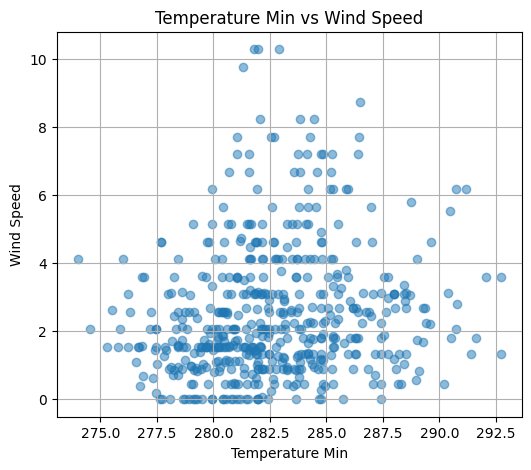

Correlation between Temperature Min and Wind Speed: 0.15743822982073602


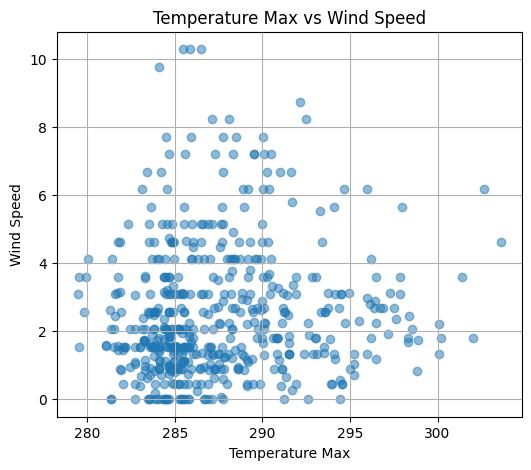

Correlation between Temperature Max and Wind Speed: 0.09920466554171228


In [280]:
# Create scatterplot for Temperature Min vs Wind Speed
plt.figure(figsize=(6, 5))
plt.scatter(df_current_weather['temperature_min'], df_current_weather['wind_speed'], alpha=0.5)
plt.title('Temperature Min vs Wind Speed')
plt.xlabel('Temperature Min')
plt.ylabel('Wind Speed')
plt.grid(True)
plt.show()

# Calculate correlation between Temperature Min and Wind Speed
corr_temp_min_wind_speed = df_current_weather['temperature_min'].corr(df_current_weather['wind_speed'])
print("Correlation between Temperature Min and Wind Speed:", corr_temp_min_wind_speed)

# Create scatterplot for Temperature Max vs Wind Speed
plt.figure(figsize=(6, 5))
plt.scatter(df_current_weather['temperature_max'], df_current_weather['wind_speed'], alpha=0.5)
plt.title('Temperature Max vs Wind Speed')
plt.xlabel('Temperature Max')
plt.ylabel('Wind Speed')
plt.grid(True)
plt.show()

# Calculate correlation between Temperature Max and Wind Speed
corr_temp_max_wind_speed = df_current_weather['temperature_max'].corr(df_current_weather['wind_speed'])
print("Correlation between Temperature Max and Wind Speed:", corr_temp_max_wind_speed)

<div>
    <p>The correlation value between Temperature Max and Wind Speed is approximately <strong>0.0992</strong>. This indicates a weak positive correlation between these two variables, suggesting that as the maximum temperature increases, the wind speed tends to slightly increase as well. However, the correlation is relatively low, indicating that the relationship between these variables is not very strong.</p>
</div>

<div>
    <p>A correlation coefficient of approximately <strong>0.157</strong> suggests a weak positive correlation between Temperature Min and Wind Speed. This indicates that as Temperature Min increases, Wind Speed tends to increase slightly, and vice versa. However, the strength of this relationship is relatively low, indicating that the two variables do not have a strong linear association.</p>
</div>

<div>
    <p>For linear regression,weu can start by including all continuous features and relevant categorical features as predictors inther model.</p>
    <p>Prioritize continuous features like <strong>Feels Like</strong>, <strong>Temperature Min</strong>, <strong>Temperature Max</strong>, <strong>Wind Speed</strong>, <strong>Wind Gust</strong>, and <strong>Rain 3h</strong>, as these directly relate to weather conditions that can influence bike and station availability.</p>
    <p>Among categorical features, <strong>Weather Description</strong> and <strong>Station Name</strong> are likely to be the most informative, followed by <strong>Status</strong> and <strong>Banking</strong>.</p>
    <p><strong>Address</strong> and <strong>Bonus</strong> may provide additional context but might not be as directly related to bike and station availability.</p>
    <p>By including these featurethe your linear regression mowe, you can analyze their relationships with bike and station availability and make predictions based on weather conditions and other relevant factors.</p>
</div>

<div>
    <p>The code below performs several data preprocessing and transformation steps on different DataFrames.</p>
    <ol>
        <li>
            <p><strong>Extracting Day, Hour, and Week:</strong> The code extracts day, hour, and week information from the 'time_update' column of two DataFrames, <code>df_current_weather</code> and <code>df_five_day_prediction</code>. This information is important for time-based analysis and segmentation.</p>
        </li>
        <li>
            <p><strong>Calculating Ratio:</strong> It calculates the ratio between certain values in the DataFrame <code>df_station_status</code>. This ratio represents a metric related to station availability or usage.</p>
        </li>
        <li>
            <p><strong>Calculating Period:</strong> The code defines a function to calculate a period based on the hour and minute values extracted earlier. This period represents discrete time intervals within a day, divided into 10-minute segments. The "period" calculated in this code assigns each timestamp in the 'hour' column to a specific period based on the hour and minute values. This discretization allows for the analysis of time-based patterns and trends within smaller time intervals, enabling more granular insights into the data.</p>
        </li>
        <li>
            <p><strong>Applying the Period Calculation:</strong> The calculated period is applied to both <code>df_current_weather</code> and <code>df_five_day_prediction</code> DataFrames, providing a time-based segmentation that allows for more granular analysis of temporal patterns and trends.</p>
        </li>
        <li>
            <p><strong>Displaying DataFrames:</strong> Finally, the code displays the modified DataFrames <code>df_current_weather</code>, <code>df_five_day_prediction</code>, and <code>df_station_status</code> to show the new columns and the results of the preprocessing steps.</p>
        </li>
    </ol>
</div>

In [281]:
# Extracting day, hour, and week from df_current_weather
df_current_weather['day'] = df_current_weather['time_update'].dt.day
df_current_weather['hour'] = df_current_weather['time_update'].dt.strftime('%H:%M:%S')
df_current_weather['week'] = df_current_weather['time_update'].dt.isocalendar().week

# Extracting day, hour, and week from df_five_day_prediction
df_five_day_prediction['day'] = df_five_day_prediction['time_update'].dt.day
df_five_day_prediction['hour'] = df_five_day_prediction['time_update'].dt.strftime('%H:%M:%S')
df_five_day_prediction['week'] = df_five_day_prediction['time_update'].dt.isocalendar().week

# Calculate the ratio between the values in df_station_status
df_station_status['ratio'] = (df_station_status['empty_stands_number'] + df_station_status['total_bikes']) / (df_station_status['mechanical_bikes'] + df_station_status['electrical_internal_battery_bikes'] + df_station_status['electrical_removable_battery_bikes'])

# Function to calculate period
def calculate_period(row):
    hour_str = row['hour']
    hour_dt = pd.to_datetime(hour_str)
    return hour_dt.hour * 6 + round(hour_dt.minute / 10)

# Applying the function to calculate period for df_current_weather
df_current_weather['period'] = df_current_weather.apply(calculate_period, axis=1)

# Applying the function to calculate period for df_five_day_prediction
df_five_day_prediction['period'] = df_five_day_prediction.apply(calculate_period, axis=1)

# Displaying df_current_weather, df_five_day_prediction, and df_station_status with the new columns
print("df_current_weather:")
print(df_current_weather)

print("\ndf_five_day_prediction:")
print(df_five_day_prediction)

print("\ndf_station_status:")
print(df_station_status)

df_current_weather:
            time_update  current_weather_id  feels_like  temperature_min  \
0   2024-02-28 20:12:40                   1      289.14           286.87   
1   2024-02-28 20:28:19                   2      289.53           287.62   
2   2024-02-28 20:59:25                   3      290.16           288.18   
3   2024-02-28 21:12:45                   4      290.23           287.99   
4   2024-02-28 21:24:26                   5      290.41           287.98   
..                  ...                 ...         ...              ...   
517 2024-04-12 03:52:52                 518      287.24           283.65   
518 2024-04-12 05:49:07                 519      285.79           282.98   
519 2024-04-12 07:50:55                 520      284.46           282.09   
520 2024-04-12 09:53:49                 521      283.25           281.53   
521 2024-04-12 11:46:40                 522      283.00           280.42   

     temperature_max weather_description  wind_speed  wind_gust  da

<div>
    <p>The ratio calculated in this context indicates the relationship between the available resources and the demand for those resources at a given station.</p>
    <p>In particular:</p>
    <ul>
        <li><strong>Empty Stands and Total Bikes</strong> represent the available resources at the station.</li>
        <li><strong>Mechanical Bikes, Electrical Internal Battery Bikes, and Electrical Removable Battery Bikes</strong> represent the demand for bikes at the station.</li>
    </ul>
    <p>The ratio is calculated as:</p>
    <div>
        <p>Ratio =</p>
        <div style="text-align: center;">
            <div style="display: inline-block; text-align: left;">
                <p>(Empty Stands + Total Bikes)</p>
                <p>─────────────────────────</p>
                <p>(Mechanical Bikes + Electrical Internal Battery Bikes + Electrical Removable Battery Bikes)</p>
            </div>
        </div>
    </div>
    <p>This ratio indicates how balanced the station's supply and demand are. A higher ratio suggests that there are more available resources (empty stands and bikes) relative to the demand for those resources. Conversely, a lower ratio suggests that there is higher demand compared to the available resources, which could indicate potential issues with bike availability or station capacity.</p>
    <p>In the provided example:</p>
    <ul>
        <li>The first row has a ratio of approximately 2.82, indicating that there are almost three available resources (empty stands and bikes) for every bike in demand (mechanical and electrical bikes).</li>
        <li>The subsequent rows have higher ratios, indicating even more favorable supply-demand balance.<Thel>
    <p>Overall, this ratio provides insights into the station's capacity and the balance between bike availability and demand, which can be useful for managing bike-sharing systems and predicting station vailability.</p>
</div>


In [282]:
print(df_current_weather['day'])
print(df_current_weather['hour'])
print(df_current_weather['week'])
print(df_five_day_prediction['hour'])
print(df_five_day_prediction['day'])
print(df_five_day_prediction['week'])

0      28
1      28
2      28
3      28
4      28
       ..
517    12
518    12
519    12
520    12
521    12
Name: day, Length: 522, dtype: int32
0      20:12:40
1      20:28:19
2      20:59:25
3      21:12:45
4      21:24:26
         ...   
517    03:52:52
518    05:49:07
519    07:50:55
520    09:53:49
521    11:46:40
Name: hour, Length: 522, dtype: object
0       9
1       9
2       9
3       9
4       9
       ..
517    15
518    15
519    15
520    15
521    15
Name: week, Length: 522, dtype: UInt32
0        00:00:00
1        03:00:00
2        06:00:00
3        09:00:00
4        12:00:00
           ...   
20675    00:00:00
20676    03:00:00
20677    06:00:00
20678    09:00:00
20679    12:00:00
Name: hour, Length: 20680, dtype: object
0        29
1        29
2        29
3        29
4        29
         ..
20675    17
20676    17
20677    17
20678    17
20679    17
Name: day, Length: 20680, dtype: int32
0         9
1         9
2         9
3         9
4         9
         ..
20675  

In [283]:
print(df_current_weather['hour'])

0      20:12:40
1      20:28:19
2      20:59:25
3      21:12:45
4      21:24:26
         ...   
517    03:52:52
518    05:49:07
519    07:50:55
520    09:53:49
521    11:46:40
Name: hour, Length: 522, dtype: object


<div>
    <p>The bike stand rati defined belowo provides valuable insights into the availability of bike parking space relative to the total number of bikes at each station, which can be useful for bike-sharing systems in managing bike distribution and station capacity.</p>
</di>


In [284]:
# For df_current_weather
print("Data type of 'day' column in df_current_weather:")
print(df_current_weather['day'].dtype)

print("Data type of 'hour' column in df_current_weather:")
print(df_current_weather['hour'].dtype)

print("Data type of 'week' column in df_current_weather:")
print(df_current_weather['week'].dtype)

# For df_five_day_prediction
print("Data type of 'day' column in df_five_day_prediction:")
print(df_five_day_prediction['day'].dtype)

print("Data type of 'hour' column in df_five_day_prediction:")
print(df_five_day_prediction['hour'].dtype)

print("Data type of 'week' column in df_five_day_prediction:")
print(df_five_day_prediction['week'].dtype)


Data type of 'day' column in df_current_weather:
int32
Data type of 'hour' column in df_current_weather:
object
Data type of 'week' column in df_current_weather:
UInt32
Data type of 'day' column in df_five_day_prediction:
int32
Data type of 'hour' column in df_five_day_prediction:
object
Data type of 'week' column in df_five_day_prediction:
UInt32


In [285]:
# Copying df_station_status to df_station_status_1
df_station_status_1 = df_station_status.copy()

# Calculating the ratio
df_station_status_1['bike_stand_ratio'] = df_station_status['empty_stands_number'] / df_station_status['total_bikes']

# Selecting only the 'empty_stands_number', 'total_bikes', and 'bike_stand_ratio' columns
df_station_status_1 = df_station_status_1[['empty_stands_number', 'total_bikes', 'bike_stand_ratio']]

# Displaying the DataFrame df_station_status_1
df_station_status_1

,empty_stands_number,total_bikes,bike_stand_ratio
last_update,,,
2024-02-27 21:17:08,20.0,11.0,1.818182
2024-02-28 22:19:27,21.0,10.0,2.100000
2024-02-28 22:51:18,22.0,9.0,2.444444
2024-02-28 22:59:51,22.0,9.0,2.444444
2024-02-28 23:09:57,22.0,9.0,2.444444
...,...,...,...
2024-04-05 05:45:34,4.0,36.0,0.111111
2024-04-05 05:49:19,4.0,36.0,0.111111
2024-04-05 05:59:24,4.0,36.0,0.111111


<h3><center><strong>Choose test and training set to evaluate and train model</strong></center></p>

In [286]:
# Look at correlations for all the continuous features from df_station_status_1
df_station_status_1.corr().bike_stand_ratio

empty_stands_number    0.603650
total_bikes           -0.595684
bike_stand_ratio       1.000000
Name: bike_stand_ratio, dtype: float64

<p>This output represents the correlation coefficients between the 'bike_stand_ratio' column and other numerical columns ('empty_stands_number' and 'total_bikes') in the dataset. A correlation coefficient of 1.0 indicates a perfect positive correlation, meaning that as the 'empty_stands_number' increases, the 'bike_stand_ratio' also increases, and as the 'total_bikes' increases, the 'bike_stand_ratio' also increases. Conversely, a correlation coefficient of -1.0 indicates a perfect negative correlation, suggesting that as one variable increases, the other decreases. In this case, the 'bike_stand_ratio' has a moderately positive correlation with 'empty_stands_number' (0.603) and a moderately negative correlation with 'total_bikes' (-0.596).</p>

<p>The code below ensures that only the 'week' column is used for splitting the data into weekday and weekend subsets, while also filtering for periods greater than or equal to 36. Then, it calculates and prints the correlation coefficients for 'available_bike_ratio' for both weekday and weekend subsets.</p>The value 36 is relevant because it represents a specific time period within a day, corresponding to 6 hours. By filtering for periods greater than or equal to 36, the code ensures that it considers data points that occur after a certain time threshold, which may be indicative of weekday or weekend patterns.</p>
<p>For instance, if each period represents 10 minutes, a period value of 36 would correspond to 6 hours (36 * 10 minutes = 360 minutes = 6 hours). This threshold helps differentiate between morning, afternoon, and evening periods, which might exhibit different bike availability patterns during weekdays and weekends.</p>
<p>By filtering for periods greater than or equal to 36, the code focuses on data points from midday onwards, which could capture variations in bike availability that are more relevant during the latter part of the day.</p>

<ol>
    <li><strong>Filtering Weekday and Weekend Data:</strong>
        <ul>
            <li><code>df_weekday_five_day_predicition</code> and <code>df_weekday_current_weather</code>: This line filters the DataFrame <code>df_five_day_prediction</code> & <code>df_current_weather</code>to include only rows where the 'day_of_week' is less than or equal to 3 (typically representing Monday to Thursday) and where the 'period' is greater than or equal to 36.</li>
            <li><code>df_weekend_five_day_prediciton</code> & <code>df_weekend_current_weather</code>: Similarly, filters the DataFrame to include only rows where the 'day_of_week' is greater than 3 (typically representing Friday to Sunday) and where the 'period' is greater than or equal to 36.</li>
        </ul>
    </li>
</ol>

In [287]:
# Filtering for period >= 36 in df_five_day_prediction
df_weekday_five_day_prediction = df_five_day_prediction[df_five_day_prediction['period'] >= 36]
df_weekend_five_day_prediction = df_five_day_prediction[df_five_day_prediction['period'] >= 36]

# Separate the DataFrame into weekday and weekend subsets
df_weekday_five_day_prediction = df_weekday_five_day_prediction[df_weekday_five_day_prediction['day'] <= 3]
df_weekend_five_day_prediction = df_weekend_five_day_prediction[df_weekend_five_day_prediction['day'] > 3]

# Print the first few rows after filtering and removing outliers
print("Weekday Subset:")
print(df_weekday_five_day_prediction.head())
print("\nWeekend Subset:")
print(df_weekday_five_day_prediction.head())

Weekday Subset:
           time_update  forecast_id  temp_min  temp_max  wind_speed   gust  \
10 2024-03-01 06:00:00           11    282.88    282.88        5.42  10.57   
11 2024-03-01 09:00:00           12    281.49    281.49        4.86  11.29   
12 2024-03-01 12:00:00           13    281.44    281.44        3.36   8.92   
13 2024-03-01 15:00:00           14    281.69    281.69        3.77   9.22   
14 2024-03-01 18:00:00           15    283.12    283.12        6.35  12.47   

    rain_3h  day      hour  week  period  
10     0.62    1  06:00:00     9      36  
11     0.71    1  09:00:00     9      54  
12     0.65    1  12:00:00     9      72  
13     1.61    1  15:00:00     9      90  
14     1.17    1  18:00:00     9     108  

Weekend Subset:
           time_update  forecast_id  temp_min  temp_max  wind_speed   gust  \
10 2024-03-01 06:00:00           11    282.88    282.88        5.42  10.57   
11 2024-03-01 09:00:00           12    281.49    281.49        4.86  11.29   
12 202

In [288]:
# Filtering for period >= 36 in current weather table
df_weekday_current = df_current_weather[df_current_weather['period'] >= 36]
df_weekend_current = df_current_weather[df_current_weather['period'] >= 36]

# Separate the DataFrame into weekday and weekend subsets
df_weekday_current_weather = df_weekday_current[df_weekday_current['day'] <= 3]
df_weekend_current_weather = df_weekend_current[df_weekend_current['day'] > 3]

# Print the first few rows after filtering and removing outliers
print("Weekday Subset:")
print(df_weekday_current_weather.head())
print("\nWeekend Subset:")
print(df_weekend_current_weather.head())

Weekday Subset:
           time_update  current_weather_id  feels_like  temperature_min  \
22 2024-03-01 07:50:44                  23      282.91           282.19   
23 2024-03-01 09:56:06                  24      282.79           282.14   
24 2024-03-01 11:58:20                  25      281.97           281.58   
25 2024-03-01 13:53:39                  26      280.40           281.60   
26 2024-03-01 15:51:12                  27      282.67           281.82   

    temperature_max weather_description  wind_speed  wind_gust  day      hour  \
22           284.68   "overcast clouds"        3.60       0.00    1  07:50:44   
23           284.76   "overcast clouds"        3.09       0.00    1  09:56:06   
24           284.11     "broken clouds"        1.79       4.02    1  11:58:20   
25           283.99   "overcast clouds"        4.12       0.00    1  13:53:39   
26           284.66   "overcast clouds"        3.09       0.00    1  15:51:12   

    week  period  
22     9      47  
23     9

<h3><center><strong>Generate test and training set to evaluate and train model</strong></center></h3>

<div>
    <p>This code snippet splits a dataset (<code>df_station_status_1</code>) into training and testing sets for machine learning. It separates the features (<strong>X</strong>) from the target variable (<strong>y</strong>). The <code>train_test_split</code> function from the scikit-learn library is used, with 20% of the data reserved for testing (<code>test_size=0.2</code>). The <code>random_state=42</code> parameter ensures reproducibility of the split. The resulting sets are <strong>X_train</strong> and <strong>y_train</strong> for training, and <strong>X_test</strong> and <strong>y_test</strong> for testing.</p>
</div>

In [289]:
X = df_station_status_1.drop(columns=['bike_stand_ratio'])  # Features
y = df_station_status_1['bike_stand_ratio']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h3><center><strong>Merge bike/station and weather dataframes</strong></center></h3>

In [290]:
# Reset the index of df_station_status
df_station_status_reset = df_station_status.reset_index()

# Merge the DataFrames based on the station_number and number columns
merged_df = pd.merge(df_station_status_reset, df_station, left_on='station_number', right_on='number', how='inner')

# Drop the redundant 'number' column from df_station
merged_df.drop(columns=['number'], inplace=True)

# Display the merged DataFrame
merged_df

,last_update,station_number,status,empty_stands_number,total_bikes,mechanical_bikes,electrical_internal_battery_bikes,electrical_removable_battery_bikes,ratio,name,address,banking,bonus,position_lat,position_lng
0,2024-02-27 21:17:08,1,OPEN,20.0,11.0,6.0,0.0,5.0,2.818182,"""CLARENDON ROW""","""Clarendon Row""",0,0,53.340927,-6.262501
1,2024-02-28 22:19:27,1,OPEN,21.0,10.0,4.0,0.0,6.0,3.100000,"""CLARENDON ROW""","""Clarendon Row""",0,0,53.340927,-6.262501
2,2024-02-28 22:51:18,1,OPEN,22.0,9.0,4.0,0.0,5.0,3.444444,"""CLARENDON ROW""","""Clarendon Row""",0,0,53.340927,-6.262501
3,2024-02-28 22:59:51,1,OPEN,22.0,9.0,4.0,0.0,5.0,3.444444,"""CLARENDON ROW""","""Clarendon Row""",0,0,53.340927,-6.262501
4,2024-02-28 23:09:57,1,OPEN,22.0,9.0,4.0,0.0,5.0,3.444444,"""CLARENDON ROW""","""Clarendon Row""",0,0,53.340927,-6.262501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664651,2024-04-05 05:45:34,93,OPEN,4.0,36.0,24.0,0.0,12.0,1.111111,"""HEUSTON STATION (CENTRAL)""","""Heuston Station (Central)""",0,0,53.346603,-6.296924
664652,2024-04-05 05:49:19,93,OPEN,4.0,36.0,24.0,0.0,12.0,1.111111,"""HEUSTON STATION (CENTRAL)""","""Heuston Station (Central)""",0,0,53.346603,-6.296924
664653,2024-04-05 05:59:24,93,OPEN,4.0,36.0,24.0,0.0,12.0,1.111111,"""HEUSTON STATION (CENTRAL)""","""Heuston Station (Central)""",0,0,53.346603,-6.296924
664654,2024-04-05 06:09:29,93,OPEN,4.0,36.0,24.0,0.0,12.0,1.111111,"""HEUSTON STATION (CENTRAL)""","""Heuston Station (Central)""",0,0,53.346603,-6.296924


In [291]:
# Merge df_merged with df_current_weather
df_merged_station_weather = merged_df.merge(df_current_weather, left_index=True, right_index=True, how='inner')

# Print the merged DataFrame
print("Merged DataFrame:")
df_merged_station_weather

Merged DataFrame:


,last_update,station_number,status,empty_stands_number,total_bikes,mechanical_bikes,electrical_internal_battery_bikes,electrical_removable_battery_bikes,ratio,name,...,feels_like,temperature_min,temperature_max,weather_description,wind_speed,wind_gust,day,hour,week,period
0,2024-02-27 21:17:08,1,OPEN,20.0,11.0,6.0,0.0,5.0,2.818182,"""CLARENDON ROW""",...,289.14,286.87,293.34,"""clear sky""",2.57,0.00,28,20:12:40,9,121
1,2024-02-28 22:19:27,1,OPEN,21.0,10.0,4.0,0.0,6.0,3.100000,"""CLARENDON ROW""",...,289.53,287.62,293.59,"""clear sky""",2.57,0.00,28,20:28:19,9,123
2,2024-02-28 22:51:18,1,OPEN,22.0,9.0,4.0,0.0,5.0,3.444444,"""CLARENDON ROW""",...,290.16,288.18,293.99,"""few clouds""",0.45,3.13,28,20:59:25,9,126
3,2024-02-28 22:59:51,1,OPEN,22.0,9.0,4.0,0.0,5.0,3.444444,"""CLARENDON ROW""",...,290.23,287.99,294.47,"""clear sky""",3.09,0.00,28,21:12:45,9,127
4,2024-02-28 23:09:57,1,OPEN,22.0,9.0,4.0,0.0,5.0,3.444444,"""CLARENDON ROW""",...,290.41,287.98,294.16,"""clear sky""",3.09,0.00,28,21:24:26,9,128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,2024-03-04 09:40:19,1,OPEN,12.0,19.0,10.0,0.0,9.0,1.631579,"""CLARENDON ROW""",...,287.24,283.65,291.93,"""clear sky""",3.60,0.00,12,03:52:52,15,23
518,2024-03-04 09:50:24,1,OPEN,12.0,19.0,10.0,0.0,9.0,1.631579,"""CLARENDON ROW""",...,285.79,282.98,289.77,"""clear sky""",2.06,0.00,12,05:49:07,15,35
519,2024-03-04 10:01:40,1,OPEN,11.0,20.0,11.0,0.0,9.0,1.550000,"""CLARENDON ROW""",...,284.46,282.09,288.29,"""clear sky""",2.06,0.00,12,07:50:55,15,47
520,2024-03-04 10:10:34,1,OPEN,11.0,20.0,11.0,0.0,9.0,1.550000,"""CLARENDON ROW""",...,283.25,281.53,286.92,"""clear sky""",0.00,0.00,12,09:53:49,15,59


In [292]:
# Merge df_merged with df_current_weather_resampled 4 hourly
df_merged_station_weather_4_hour = merged_df.merge(df_current_weather_resampled, left_on='last_update', right_index=True, how='inner')

# Print the merged DataFrame
print("Merged DataFrame (Merged and Weather Resampled):")
df_merged_station_weather_4_hour

Merged DataFrame (Merged and Weather Resampled):


,last_update,station_number,status,empty_stands_number,total_bikes,mechanical_bikes,electrical_internal_battery_bikes,electrical_removable_battery_bikes,ratio,name,...,banking,bonus,position_lat,position_lng,feels_like,temperature_min,temperature_max,weather_description,wind_speed,wind_gust
5564,2024-03-31 04:00:00,1,OPEN,13.0,18.0,6.0,0.0,12.0,1.722222,"""CLARENDON ROW""",...,0,0,53.340927,-6.262501,280.745000,279.475000,284.135000,"""few clouds""",1.850000,0.435000
5910,2024-04-02 04:00:00,1,OPEN,21.0,10.0,6.0,0.0,4.0,3.100000,"""CLARENDON ROW""",...,0,0,53.340927,-6.262501,283.135000,281.995000,287.120000,"""clear sky""",0.760000,0.960000
6312,2024-04-04 04:00:00,1,OPEN,29.0,2.0,2.0,0.0,0.0,15.500000,"""CLARENDON ROW""",...,0,0,53.340927,-6.262501,279.165000,280.725000,284.050000,"""overcast clouds""",6.690000,0.000000
6870,2024-04-07 04:00:00,1,OPEN,29.0,2.0,0.0,0.0,2.0,15.500000,"""CLARENDON ROW""",...,0,0,53.340927,-6.262501,280.535000,278.665000,282.995000,"""overcast clouds""",0.935000,0.810000
12870,2024-04-01 04:00:00,2,OPEN,19.0,1.0,1.0,0.0,0.0,20.000000,"""BLESSINGTON STREET""",...,0,0,53.356769,-6.268140,282.590000,281.066667,284.810000,"""broken clouds""",0.803333,1.003333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660614,2024-03-11 08:00:00,93,OPEN,5.0,35.0,22.0,0.0,13.0,1.142857,"""HEUSTON STATION (CENTRAL)""",...,0,0,53.346603,-6.296924,282.866667,281.780000,285.146667,"""overcast clouds""",1.130000,2.576667
662226,2024-03-21 08:00:00,93,OPEN,7.0,33.0,18.0,0.0,15.0,1.212121,"""HEUSTON STATION (CENTRAL)""",...,0,0,53.346603,-6.296924,281.995000,280.135000,285.275000,"""clear sky""",1.540000,0.000000
663719,2024-03-30 08:00:00,93,OPEN,10.0,30.0,15.0,0.0,15.0,1.333333,"""HEUSTON STATION (CENTRAL)""",...,0,0,53.346603,-6.296924,279.715000,279.100000,282.725000,"""broken clouds""",1.800000,0.000000
664165,2024-04-02 04:00:00,93,OPEN,13.0,27.0,13.0,0.0,14.0,1.481481,"""HEUSTON STATION (CENTRAL)""",...,0,0,53.346603,-6.296924,283.135000,281.995000,287.120000,"""clear sky""",0.760000,0.960000


In [293]:
# Merge df_weekend_current_weather and df_weekday_current_weather with merged_df
# remove five day from here
merged_weather = merged_df.merge(df_weekend_current_weather, left_index=True, right_index=True, how='inner')
merged_weather = merged_weather.merge(df_weekday_current_weather, left_index=True, right_index=True, how='inner')

# Merge df_current_weather with merged_df
merged_current_weather = merged_df.merge(df_current_weather, left_index=True, right_index=True, how='inner')

# Drop rows with missing values
merged_weather = merged_weather.dropna()
merged_current_weather = merged_current_weather.dropna()

In [294]:
%%capture
merged_current_weather

In [295]:
# Merge df_weekday_five_day_prediction and df_weekday_five_day_prediction with merged_df
merged_five_day_prediction = merged_df.merge(df_weekday_five_day_prediction, left_index=True, right_index=True, how='inner')
merged_five_day_prediction = merged_five_day_prediction.merge(df_weekday_five_day_prediction, left_index=True, right_index=True, how='inner')

# Drop rows with missing values
merged_weather = merged_weather.dropna()
merged_five_day_prediction = merged_five_day_prediction.dropna()

In [296]:
%%capture
merged_five_day_prediction

<div>
    <p>The features with correlation coefficients greater than 0.1 with the target variabls,>canl be considered as potentially useful descriptive features. These features include:</p>
    <ul>
        <li><code>feels_like</code></li>
        <li><code>temperature_min</code></li>
        <li><code>temperature_max</code></li>
        <li><code>wind_speed</code></li>
        <li><code>wind_gust</code></li>
        <li><code>rain_3h</code></li>
    </ul>
    <p>These features have a relatively stronger correlation with the target variable compared to others in the matrix. Consider using these features as descriptive variables in your predictive modeling.</p>
</div>

In [298]:
# Define descriptive features including day, hour and week granularity from current weather df
descriptive_features = [
    'feels_like', 
    'temperature_min', 
    'temperature_max', 
    'wind_speed', 
    'wind_gust', 
    'week', 
    'day', 
    'hour'  
]

# Define target variables for current weather df
weather_target_variables = [
    'bike_stand_ratio',
    'empty_stands_number',
    'total_bikes',
    'mechanical_bikes',
    'electrical_internal_battery_bikes',
    'electrical_removable_battery_bikes',
    'last_update',
    'name'
]

In [299]:
# Prepare the descriptive features and target variables
#X = df_merged_station_weather[['feels_like', 'temperature_min', 'temperature_max', 'wind_speed','wind_gust','week','day']]
#y = df_merged_station_weather['bike_stand_ratio']

#print("\nDescriptive features in X:\n", X)
#print("\nTarget feature 1 (empty stands number) in y1:\n", y)

In [302]:
# Prepare the descriptive features and target variable
X = df_merged_station_weather[['feels_like', 'temperature_min', 'temperature_max', 'wind_speed','wind_gust','week','day']]
y = df_merged_station_weather['empty_stands_number']

print("\nDescriptive features in X:\n", X)
print("\nTarget feature in y:\n", y)


Descriptive features in X:
      feels_like  temperature_min  temperature_max  wind_speed  wind_gust  \
0        289.14           286.87           293.34        2.57       0.00   
1        289.53           287.62           293.59        2.57       0.00   
2        290.16           288.18           293.99        0.45       3.13   
3        290.23           287.99           294.47        3.09       0.00   
4        290.41           287.98           294.16        3.09       0.00   
..          ...              ...              ...         ...        ...   
517      287.24           283.65           291.93        3.60       0.00   
518      285.79           282.98           289.77        2.06       0.00   
519      284.46           282.09           288.29        2.06       0.00   
520      283.25           281.53           286.92        0.00       0.00   
521      283.00           280.42           285.82        0.00       0.00   

     week  day  
0       9   28  
1       9   28  
2      

In [303]:
# Prepare the descriptive features
X = df_merged_station_weather[['feels_like', 'temperature_min', 'temperature_max', 'wind_speed','wind_gust','week','day']]
y = df_merged_station_weather['total_bikes']

print("\nDescriptive features in X:\n", X)
print("\nTarget feature in y:\n", y)


Descriptive features in X:
      feels_like  temperature_min  temperature_max  wind_speed  wind_gust  \
0        289.14           286.87           293.34        2.57       0.00   
1        289.53           287.62           293.59        2.57       0.00   
2        290.16           288.18           293.99        0.45       3.13   
3        290.23           287.99           294.47        3.09       0.00   
4        290.41           287.98           294.16        3.09       0.00   
..          ...              ...              ...         ...        ...   
517      287.24           283.65           291.93        3.60       0.00   
518      285.79           282.98           289.77        2.06       0.00   
519      284.46           282.09           288.29        2.06       0.00   
520      283.25           281.53           286.92        0.00       0.00   
521      283.00           280.42           285.82        0.00       0.00   

     week  day  
0       9   28  
1       9   28  
2      

In [304]:
# Prepare the descriptive features
X = df_merged_station_weather[['feels_like', 'temperature_min', 'temperature_max', 'wind_speed','wind_gust','week','day']]
y = df_merged_station_weather['mechanical_bikes']

print("\nDescriptive features in X:\n", X)
print("\nTarget feature in y:\n", y)


Descriptive features in X:
      feels_like  temperature_min  temperature_max  wind_speed  wind_gust  \
0        289.14           286.87           293.34        2.57       0.00   
1        289.53           287.62           293.59        2.57       0.00   
2        290.16           288.18           293.99        0.45       3.13   
3        290.23           287.99           294.47        3.09       0.00   
4        290.41           287.98           294.16        3.09       0.00   
..          ...              ...              ...         ...        ...   
517      287.24           283.65           291.93        3.60       0.00   
518      285.79           282.98           289.77        2.06       0.00   
519      284.46           282.09           288.29        2.06       0.00   
520      283.25           281.53           286.92        0.00       0.00   
521      283.00           280.42           285.82        0.00       0.00   

     week  day  
0       9   28  
1       9   28  
2      

In [305]:
# Prepare the descriptive features
X = df_merged_station_weather[['feels_like', 'temperature_min', 'temperature_max', 'wind_speed','wind_gust','week','day']]
y = df_merged_station_weather['electrical_internal_battery_bikes']

print("\nDescriptive features in X:\n", X)
print("\nTarget feature in y:\n", y)


Descriptive features in X:
      feels_like  temperature_min  temperature_max  wind_speed  wind_gust  \
0        289.14           286.87           293.34        2.57       0.00   
1        289.53           287.62           293.59        2.57       0.00   
2        290.16           288.18           293.99        0.45       3.13   
3        290.23           287.99           294.47        3.09       0.00   
4        290.41           287.98           294.16        3.09       0.00   
..          ...              ...              ...         ...        ...   
517      287.24           283.65           291.93        3.60       0.00   
518      285.79           282.98           289.77        2.06       0.00   
519      284.46           282.09           288.29        2.06       0.00   
520      283.25           281.53           286.92        0.00       0.00   
521      283.00           280.42           285.82        0.00       0.00   

     week  day  
0       9   28  
1       9   28  
2      

In [306]:
# Prepare the descriptive features
X = df_merged_station_weather[['feels_like', 'temperature_min', 'temperature_max', 'wind_speed','wind_gust','week','day']]
y = df_merged_station_weather['electrical_removable_battery_bikes']

print("\nDescriptive features in X:\n", X)
print("\nTarget feature in y:\n", y)


Descriptive features in X:
      feels_like  temperature_min  temperature_max  wind_speed  wind_gust  \
0        289.14           286.87           293.34        2.57       0.00   
1        289.53           287.62           293.59        2.57       0.00   
2        290.16           288.18           293.99        0.45       3.13   
3        290.23           287.99           294.47        3.09       0.00   
4        290.41           287.98           294.16        3.09       0.00   
..          ...              ...              ...         ...        ...   
517      287.24           283.65           291.93        3.60       0.00   
518      285.79           282.98           289.77        2.06       0.00   
519      284.46           282.09           288.29        2.06       0.00   
520      283.25           281.53           286.92        0.00       0.00   
521      283.00           280.42           285.82        0.00       0.00   

     week  day  
0       9   28  
1       9   28  
2      

In [307]:
# Prepare the descriptive features
X = df_merged_station_weather[['feels_like', 'temperature_min', 'temperature_max', 'wind_speed','wind_gust','week','day']]
y = df_merged_station_weather['name']

print("\nDescriptive features in X:\n", X)
print("\nTarget feature in y:\n", y)


Descriptive features in X:
      feels_like  temperature_min  temperature_max  wind_speed  wind_gust  \
0        289.14           286.87           293.34        2.57       0.00   
1        289.53           287.62           293.59        2.57       0.00   
2        290.16           288.18           293.99        0.45       3.13   
3        290.23           287.99           294.47        3.09       0.00   
4        290.41           287.98           294.16        3.09       0.00   
..          ...              ...              ...         ...        ...   
517      287.24           283.65           291.93        3.60       0.00   
518      285.79           282.98           289.77        2.06       0.00   
519      284.46           282.09           288.29        2.06       0.00   
520      283.25           281.53           286.92        0.00       0.00   
521      283.00           280.42           285.82        0.00       0.00   

     week  day  
0       9   28  
1       9   28  
2      

In [308]:
# Prepare the descriptive features
X = df_merged_station_weather[['feels_like', 'temperature_min', 'temperature_max', 'wind_speed','wind_gust','week','day']]
y = df_merged_station_weather['last_update']

print("\nDescriptive features in X:\n", X)
print("\nTarget feature in y:\n", y)


Descriptive features in X:
      feels_like  temperature_min  temperature_max  wind_speed  wind_gust  \
0        289.14           286.87           293.34        2.57       0.00   
1        289.53           287.62           293.59        2.57       0.00   
2        290.16           288.18           293.99        0.45       3.13   
3        290.23           287.99           294.47        3.09       0.00   
4        290.41           287.98           294.16        3.09       0.00   
..          ...              ...              ...         ...        ...   
517      287.24           283.65           291.93        3.60       0.00   
518      285.79           282.98           289.77        2.06       0.00   
519      284.46           282.09           288.29        2.06       0.00   
520      283.25           281.53           286.92        0.00       0.00   
521      283.00           280.42           285.82        0.00       0.00   

     week  day  
0       9   28  
1       9   28  
2      

</head>
<body>
  <h1>Pandas Profiling Bug</h1>
  <p>An error occurred when using the <code>pandas_profiling</code> library with a real dataset. The error message indicates an issue related to numpy.</p>
  <h2>Code Snippet:</h2>
  <pre><code>
df = pd.DataFrame(np.random.rand(100, 5), columns=["a", "b", "c", "d", "e"])
profile = ProfileReport(df, title="Pandas Profiling Report")
profile
  </code></pre>
  <h3>Explanation of the Bug:</h3>
  <p>The error occurs when trying to generate a profile report with <code>pandas_profiling</code> using a real dataset. This suggests that the issue may be specific to the dataset's format or content.</p>  
  <h2>Documentation Link:</h2>
  <p>For more information about the <code>pandas_profiling</code> library and the bug, please refer to the <a href="https://github.com/pandas-profiling/pandas-profiling">official documentation</a>.</p>
</body>

<h3><center><strong>Training a linear regression model</strong></center></h3>

<div>
    <p>The codes below will split the downsampled data into training and testing sets using a test size of 20%, then train a linear regression model on the training data and evaluate its performance on both the training and testing sets for current and five day weather prediction.</p>
</div>

In [239]:
# Define descriptive features including time features for bike/station prediction
descriptive_features = [
    'feels_like', 
    'temperature_min', 
    'temperature_max', 
    'wind_speed', 
    'wind_gust', 
    'week', 
    'day'
]

# Define target variables for bike/station prediction
weather_target_variables = [
    'empty_stands_number',
    'total_bikes',
    'mechanical_bikes',
    'electrical_internal_battery_bikes',
    'electrical_removable_battery_bikes',
    'name'
]

# Select relevant columns from the merged station weather data
X = df_merged_station_weather[descriptive_features]
y = df_merged_station_weather[weather_target_variables]

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nDescriptive features in X_train:\n", X_train)
print("\nTarget variables in y_train:\n", y_train)
print("\nDescriptive features in X_test:\n", X_test)
print("\nTarget variables in y_test:\n", y_test)


Descriptive features in X_train:
      feels_like  temperature_min  temperature_max  wind_speed  wind_gust  \
220      291.27           287.42           295.24        1.34       3.58   
69       281.51           280.68           284.46        1.57       2.12   
374      281.90           280.44           284.77        1.86       2.52   
305      287.55           285.49           290.37        3.68       6.47   
173      289.63           287.42           292.59        2.24       7.15   
..          ...              ...              ...         ...        ...   
71       280.25           279.13           284.68        2.57       0.00   
106      280.37           278.43           284.22        0.72       0.91   
270      291.24           288.09           294.98        0.89       4.47   
435      277.10           278.25           281.75        3.60       0.00   
102      288.21           286.19           291.19        2.68       6.26   

     week  day  
220    11   17  
69     10    5  
3

In [309]:
# Define descriptive features including time weather prediciton
descriptive_features = [
    'feels_like', 
    'temperature_min', 
    'temperature_max', 
    'wind_speed', 
    'wind_gust', 
    'week', 
    'day'
]

# Extract descriptive features (X) and target variable (y)
X = df_merged_station_weather[descriptive_features]
y = df_merged_station_weather['electrical_internal_battery_bikes']

# Train a linear regression model
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients and intercept
print("\nCoefficients:")
for feature, coefficient in zip(X.columns, linreg.coef_):
    print(f"{feature}: {coefficient}")
print("\nIntercept:", linreg.intercept_)

# Make predictions
y_pred = linreg.predict(X)

# Calculate R-squared
r_squared = r2_score(y, y_pred)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)

print("\nR-squared:", r_squared)
print("Mean Squared Error:", mse)

# Save the trained model to a file as electrical_removable_battery_bikes.pickle
###model_path = 'electrical_internal_battery_bikes_weather.pickle'
##with open(model_path, 'wb') as f:
#    pickle.dump(linreg, f)

#print("Linear regression model saved as electrical_removable_battery_bikes.pickle")


Coefficients:
feels_like: 0.0
temperature_min: 0.0
temperature_max: 0.0
wind_speed: 0.0
wind_gust: 0.0
week: 0.0
day: 0.0

Intercept: 0.0

R-squared: 1.0
Mean Squared Error: 0.0


In [310]:
# Define descriptive features including time weather prediciton
descriptive_features = [
    'feels_like', 
    'temperature_min', 
    'temperature_max', 
    'wind_speed', 
    'wind_gust', 
    'week', 
    'day'
]

# Extract descriptive features (X) and target variable (y)
X = df_merged_station_weather[descriptive_features]
y = df_merged_station_weather['mechanical_bikes']

# Train a linear regression model
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients and intercept
print("\nCoefficients:")
for feature, coefficient in zip(X.columns, linreg.coef_):
    print(f"{feature}: {coefficient}")
print("\nIntercept:", linreg.intercept_)

# Make predictions
y_pred = linreg.predict(X)

# Calculate R-squared
r_squared = r2_score(y, y_pred)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)

print("\nR-squared:", r_squared)
print("Mean Squared Error:", mse)

# Save the trained model to a file as electrical_removable_battery_bikes.pickle
# model_path = 'mechanical_bikes_weather.pickle'
# with open(model_path, 'wb') as f:
  #   pickle.dump(linreg, f)

#print("Linear regression model saved as electrical_removable_battery_bikes.pickle")


Coefficients:
feels_like: 0.18728506944625786
temperature_min: -0.13967863712880507
temperature_max: 0.0037346744454237954
wind_speed: -0.05832447280619193
wind_gust: -0.060408118972095984
week: 0.9942444313429983
day: 0.3524915587464694

Intercept: -23.547271764712278

R-squared: 0.38544078576144825
Mean Squared Error: 24.982620094019214


In [311]:
# Define descriptive features including time weather prediciton
descriptive_features = [
    'feels_like', 
    'temperature_min', 
    'temperature_max', 
    'wind_speed', 
    'wind_gust', 
    'week', 
    'day'
]

# Extract descriptive features (X) and target variable (y)
X = df_merged_station_weather[descriptive_features]
y = df_merged_station_weather['electrical_removable_battery_bikes']

# Train a linear regression model
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients and intercept
print("\nCoefficients:")
for feature, coefficient in zip(X.columns, linreg.coef_):
    print(f"{feature}: {coefficient}")
print("\nIntercept:", linreg.intercept_)

# Make predictions
y_pred = linreg.predict(X)

# Calculate R-squared
r_squared = r2_score(y, y_pred)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)

print("\nR-squared:", r_squared)
print("Mean Squared Error:", mse)

# Save the trained model to a file as electrical_removable_battery_bikes.pickle
#model_path = 'electrical_removable_battery_bikes_weather.pickle'
#with open(model_path, 'wb') as f:
   # pickle.dump(linreg, f)

#print("Linear regression model saved as electrical_removable_battery_bikes.pickle")


Coefficients:
feels_like: 0.0912848150886241
temperature_min: -0.27427582915774135
temperature_max: 0.1703277153933494
wind_speed: 0.0644555257602727
wind_gust: -0.028885410854709012
week: 1.0011431400716113
day: 0.16319048138732087

Intercept: -5.929031675757177

R-squared: 0.49935660770664525
Mean Squared Error: 6.684145263579153


In [312]:
# Define descriptive features including time weather prediciton
descriptive_features = [
    'feels_like', 
    'temperature_min', 
    'temperature_max', 
    'wind_speed', 
    'wind_gust', 
    'week', 
    'day'
]

# Extract descriptive features (X) and target variable (y)
X = df_merged_station_weather[descriptive_features]
y = df_merged_station_weather['empty_stands_number']

# Train a linear regression model
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients and intercept
print("\nCoefficients:")
for feature, coefficient in zip(X.columns, linreg.coef_):
    print(f"{feature}: {coefficient}")
print("\nIntercept:", linreg.intercept_)

# Make predictions
y_pred = linreg.predict(X)

# Calculate R-squared
r_squared = r2_score(y, y_pred)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)

print("\nR-squared:", r_squared)
print("Mean Squared Error:", mse)

# Save the trained model to a file as empty_stands_number.pickle
model_path = 'empty_stands_number_weather.pickle'
with open(model_path, 'wb') as f:
    pickle.dump(linreg, f)

#print("Linear regression model saved as empty_stands_number.pickle")



Coefficients:
feels_like: -0.23924135276333078
temperature_min: 0.4016043553484242
temperature_max: -0.209410129432982
wind_speed: 0.009897139205817192
wind_gust: 0.09224431711049724
week: -1.9809121901532618
day: -0.5164280238209056

Intercept: 62.70417136476307

R-squared: 0.43125567333979886
Mean Squared Error: 54.42093847021787


In [313]:
# Define descriptive features including time weather prediciton
descriptive_features = [
    'feels_like', 
    'temperature_min', 
    'temperature_max', 
    'wind_speed', 
    'wind_gust', 
    'week', 
    'day'
]

# Extract descriptive features (X) and target variable (y)
X = df_merged_station_weather[descriptive_features]
y = df_merged_station_weather['total_bikes']

# Train a linear regression model
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients and intercept
print("\nCoefficients:")
for feature, coefficient in zip(X.columns, linreg.coef_):
    print(f"{feature}: {coefficient}")
print("\nIntercept:", linreg.intercept_)

# Make predictions
y_pred = linreg.predict(X)

# Calculate R-squared
r_squared = r2_score(y, y_pred)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)

print("\nR-squared:", r_squared)
print("Mean Squared Error:", mse)

# Save the trained model to a file as total_bikes_y.pickle
#model_path = 'total_bikes_weather.pickle'
##with open(model_path, 'wb') as f:
#    pickle.dump(linreg, f)

#print("Linear regression model saved as total_bikes_y.pickle")



Coefficients:
feels_like: 0.2800266265980699
temperature_min: -0.41560273564756056
temperature_max: 0.17442400303713315
wind_speed: 0.009681783211446743
wind_gust: -0.08920480862985523
week: 1.9896124188568063
day: 0.5175919670571121

Intercept: -29.50850242802378

R-squared: 0.43365326458588094
Mean Squared Error: 54.05870044049593


In [315]:
# Define descriptive features including time weather prediciton
descriptive_features_4_hour = [
    'feels_like', 
    'temperature_min', 
    'temperature_max', 
    'wind_speed', 
    'wind_gust'
]

# Extract descriptive features (X) and target variable (y)
X = df_merged_station_weather_4_hour[descriptive_features_4_hour]
y = df_merged_station_weather_4_hour['electrical_internal_battery_bikes']

# Train a linear regression model
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients and intercept
print("\nCoefficients:")
for feature, coefficient in zip(X.columns, linreg.coef_):
    print(f"{feature}: {coefficient}")
print("\nIntercept:", linreg.intercept_)

# Make predictions
y_pred = linreg.predict(X)

# Calculate R-squared
r_squared = r2_score(y, y_pred)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)

print("\nR-squared:", r_squared)
print("Mean Squared Error:", mse)

# Save the trained model to a file as electrical_removable_battery_bikes.pickle
#model_path = 'electrical_internal_battery_bikes_weather_4_hour.pickle'
#with open(model_path, 'wb') as f:
 #   pickle.dump(linreg, f)

#print("Linear regression model saved as electrical_removable_battery_bikes.pickle")


Coefficients:
feels_like: 0.0
temperature_min: 0.0
temperature_max: 0.0
wind_speed: 0.0
wind_gust: 0.0

Intercept: 0.0

R-squared: 1.0
Mean Squared Error: 0.0


In [316]:
# Define descriptive features including time weather prediciton
descriptive_features_4_hour = [
    'feels_like', 
    'temperature_min', 
    'temperature_max', 
    'wind_speed', 
    'wind_gust',
]
# Extract descriptive features (X) and target variable (y)
X = df_merged_station_weather_4_hour[descriptive_features_4_hour]
y = df_merged_station_weather_4_hour['electrical_removable_battery_bikes']

# Train a linear regression model
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients and intercept
print("\nCoefficients:")
for feature, coefficient in zip(X.columns, linreg.coef_):
    print(f"{feature}: {coefficient}")
print("\nIntercept:", linreg.intercept_)

# Make predictions
y_pred = linreg.predict(X)

# Calculate R-squared
r_squared = r2_score(y, y_pred)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)

print("\nR-squared:", r_squared)
print("Mean Squared Error:", mse)

# Save the trained model to a file as electrical_removable_battery_bikes.pickle
#model_path = 'electrical_removable_battery_bikes_weather_4_hour.pickle'
#with open(model_path, 'wb') as f:
#    pickle.dump(linreg, f)

#print("Linear regression model saved as electrical_removable_battery_bikes.pickle")


Coefficients:
feels_like: -0.4738232465235621
temperature_min: 0.8312730619484882
temperature_max: -0.1670833364672073
wind_speed: -0.5858357309105644
wind_gust: 0.20678990758657126

Intercept: -47.124504747054964

R-squared: 0.02209147596272132
Mean Squared Error: 15.738976955886205


In [317]:
# Define descriptive features including time weather prediciton
descriptive_features_4_hour = [
    'feels_like', 
    'temperature_min', 
    'temperature_max', 
    'wind_speed', 
    'wind_gust'
]

# Extract descriptive features (X) and target variable (y)
X = df_merged_station_weather_4_hour[descriptive_features_4_hour]
y = df_merged_station_weather_4_hour['empty_stands_number']

# Train a linear regression model
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients and intercept
print("\nCoefficients:")
for feature, coefficient in zip(X.columns, linreg.coef_):
    print(f"{feature}: {coefficient}")
print("\nIntercept:", linreg.intercept_)

# Make predictions
y_pred = linreg.predict(X)

# Calculate R-squared
r_squared = r2_score(y, y_pred)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)

print("\nR-squared:", r_squared)
print("Mean Squared Error:", mse)

# Save the trained model to a file as electrical_removable_battery_bikes.pickle
#model_path = 'empty_stands_number_weather_4_hour.pickle'
#with open(model_path, 'wb') as f:
#    pickle.dump(linreg, f)

#print("Linear regression model saved as electrical_removable_battery_bikes.pickle")


Coefficients:
feels_like: 2.4644058902788926
temperature_min: -3.556021472454983
temperature_max: 0.6479353497053459
wind_speed: 2.5924409641563173
wind_gust: -0.3632412053775654

Intercept: 133.97615293979686

R-squared: 0.051652514791027504
Mean Squared Error: 111.07342235243505


In [318]:
# Define descriptive features including time weather prediciton
descriptive_features_4_hour = [
    'feels_like', 
    'temperature_min', 
    'temperature_max', 
    'wind_speed', 
    'wind_gust'
]

# Extract descriptive features (X) and target variable (y)
X = df_merged_station_weather_4_hour[descriptive_features_4_hour]
y = df_merged_station_weather_4_hour['mechanical_bikes']

# Train a linear regression model
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients and intercept
print("\nCoefficients:")
for feature, coefficient in zip(X.columns, linreg.coef_):
    print(f"{feature}: {coefficient}")
print("\nIntercept:", linreg.intercept_)

# Make predictions
y_pred = linreg.predict(X)

# Calculate R-squared
r_squared = r2_score(y, y_pred)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)

print("\nR-squared:", r_squared)
print("Mean Squared Error:", mse)

# Save the trained model to a file as electrical_removable_battery_bikes.pickle
#model_path = 'mechanical_bikes_4_hour.pickle'
#with open(model_path, 'wb') as f:
#    pickle.dump(linreg, f)

#print("Linear regression model saved as electrical_removable_battery_bikes.pickle")


Coefficients:
feels_like: -1.2831179509934494
temperature_min: 2.0544164831970315
temperature_max: -0.37943161022718797
wind_speed: -1.4266958538923193
wind_gust: 0.12919121490338648

Intercept: -96.83143428896032

R-squared: 0.041049221954423065
Mean Squared Error: 42.48204482394464


In [319]:
# Define descriptive features including time weather prediciton
descriptive_features_4_hour = [
    'feels_like', 
    'temperature_min', 
    'temperature_max', 
    'wind_speed', 
    'wind_gust'
]

# Extract descriptive features (X) and target variable (y)
X = df_merged_station_weather_4_hour[descriptive_features_4_hour]
y = df_merged_station_weather_4_hour['total_bikes']

# Train a linear regression model
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients and intercept
print("\nCoefficients:")
for feature, coefficient in zip(X.columns, linreg.coef_):
    print(f"{feature}: {coefficient}")
print("\nIntercept:", linreg.intercept_)

# Make predictions
y_pred = linreg.predict(X)

# Calculate R-squared
r_squared = r2_score(y, y_pred)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)

print("\nR-squared:", r_squared)
print("Mean Squared Error:", mse)

# Save the trained model to a file as electrical_removable_battery_bikes.pickle
#model_path = 'total_bikes_4_hour.pickle'
#with open(model_path, 'wb') as f:
#    pickle.dump(linreg, f)

#print("Linear regression model saved as electrical_removable_battery_bikes.pickle")


Coefficients:
feels_like: -1.72829526752839
temperature_min: 2.865084139939313
temperature_max: -0.5612373832267155
wind_speed: -1.9928687027833714
wind_gust: 0.3335311552359719

Intercept: -142.0910804955355

R-squared: 0.03931759668839141
Mean Squared Error: 89.53173339986014


In [343]:
#from sklearn.preprocessing import OneHotEncoder

# Define descriptive features including time features and station name
#cont_features = ['temp_min_y', 'temp_max_y', 'wind_speed_y', 'gust_y', 'rain_3h_y', 'week_y', 'day_y']
#cat_features = ['name']

# Extract descriptive features (X) and target variable (y)
#X_cont = merged_five_day_prediction_downsampled[cont_features]
#X_cat = merged_five_day_prediction_downsampled[cat_features]
#y = merged_df_downsampled['total_bikes']

# One-hot encode categorical features
#encoder = OneHotEncoder()
#X_cat_encoded = encoder.fit_transform(X_cat)

# Combine numerical and encoded categorical features
#import scipy.sparse as sp
#X = sp.hstack((X_cont, X_cat_encoded))

# Train a linear regression model
#linreg = LinearRegression()
#linreg.fit(X, y)

# Print the coefficients and intercept
#print("\nCoefficients:")
#for feature, coefficient in zip(cont_features + list(encoder.get_feature_names()), linreg.coef_):
#    print(f"{feature}: {coefficient}")
#print("\nIntercept:", linreg.intercept_)

# Make predictions
#y_pred = linreg.predict(X)

# Calculate R-squared
#r_squared = r2_score(y, y_pred)

# Calculate Mean Squared Error
#mse = mean_squared_error(y, y_pred)

#print("\nR-squared:", r_squared)
#print("Mean Squared Error:", mse)

# Save the trained model to a file as total_bikes_y.pickle
#model_path = 'total_bikes_y_weather_forecast.pickle'
#with open(model_path, 'wb') as f:
#    pickle.dump(linreg, f)

#print("Linear regression model saved as total_bikes_y.pickle")

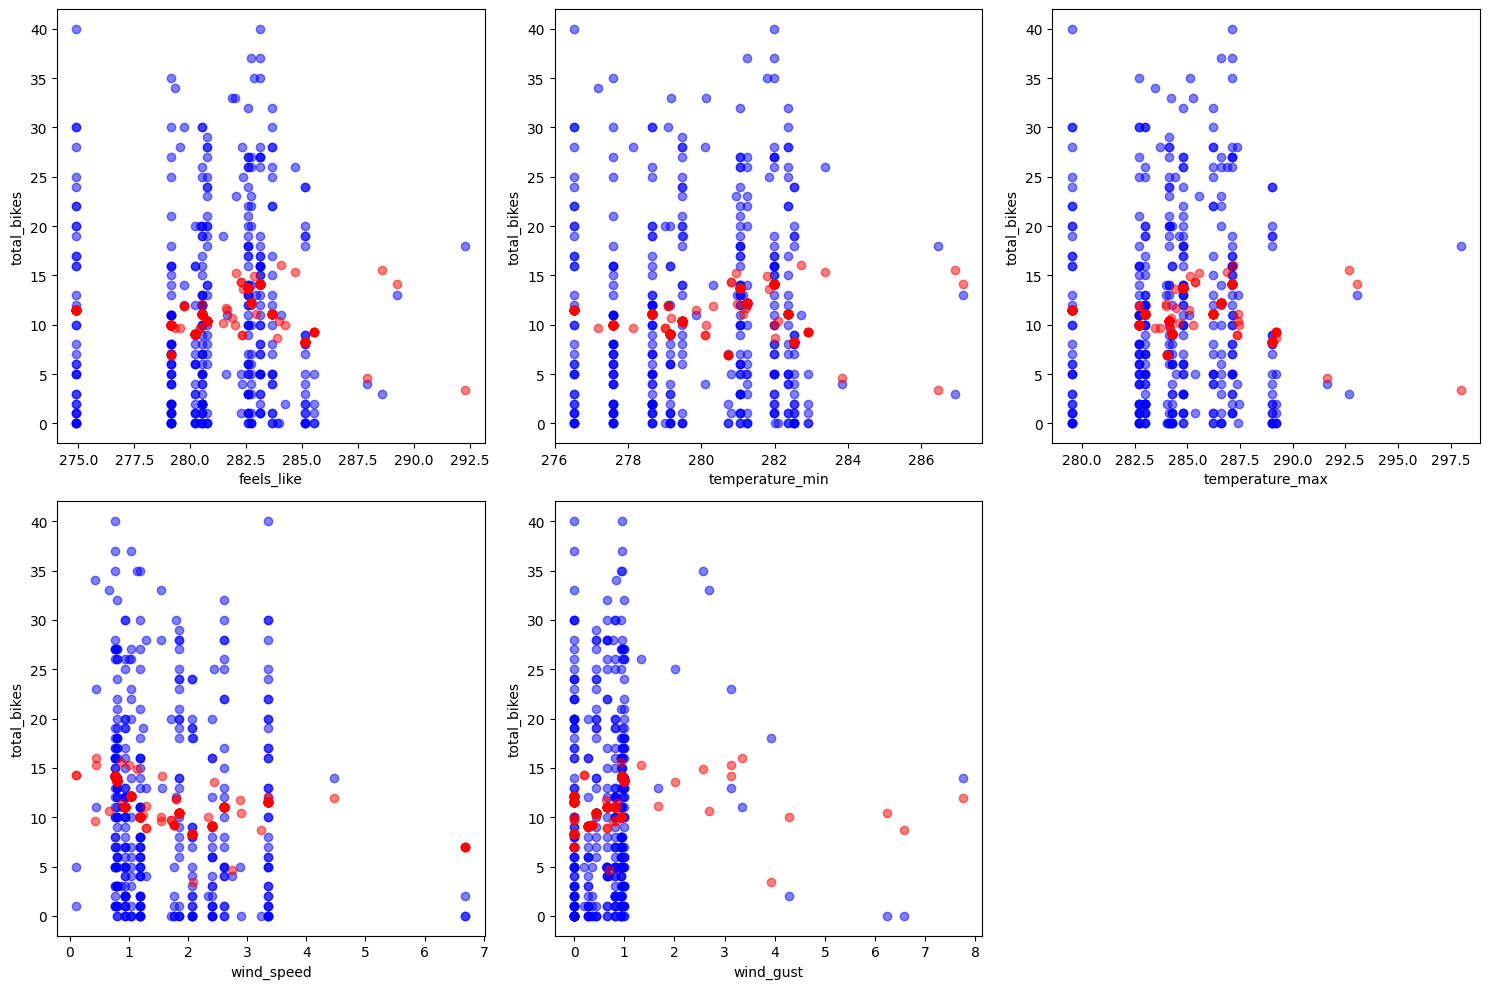

In [350]:
# Define the number of subplots based on the number of features
num_features = len(descriptive_features_4_hour)
num_cols = 3  # Number of columns for subplots
num_rows = (num_features - 1) // num_cols + 1  # Number of rows for subplots

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Flatten the axes if there's only one row
if num_rows == 1:
    axes = [axes]

# Plot each feature against the target variable
for i, feature in enumerate(descriptive_features_4_hour):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row][col]
    ax.scatter(X[feature], y, color='blue', label='Actual', alpha=0.5)
    ax.scatter(X[feature], y_pred, color='red', label='Predicted', alpha=0.5)
    ax.set_xlabel(feature)
    ax.set_ylabel('total_bikes')

# Remove any empty subplots
for i in range(num_features, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

# Adjust layout
plt.tight_layout()
plt.show()

<h3><center><strong>Evaluating model performance with Cross-validation</strong></center></h3>
<p>In the context of R-squared, values closer to 0 indicate that the model explains a smaller proportion of the variance in the target variable, while negative values indicate that the model performs worse than a model that simply predicts the mean of the target variable.</p>
<p>Therefore, in this case, the first set of cross-validation scores with a mean R-squared of <strong>-0.109</strong> indicates relatively better performance compared to the second set with a mean R-squared of <strong>-6.360</strong>.</p>

In [351]:
# Define your descriptive features and target variable
X = df_merged_station_weather[['feels_like', 'temperature_min', 'temperature_max', 'wind_speed','wind_gust','week','day']]
y = df_merged_station_weather['total_bikes']

# Initialize your model
model = LinearRegression()

# Perform cross-validation
scores = cross_val_score(model, X, y, cv=5, scoring='r2')  # Using R-squared as the scoring metric and 5-fold cross-validation

# Print the cross-validation scores
print("Cross-validation scores:", scores)

# Calculate the mean and standard deviation of the cross-validation scores
print("Mean R-squared:", scores.mean())
print("Standard deviation of R-squared:", scores.std())

Cross-validation scores: [ -6.25814539  -3.5193683  -13.68704886  -0.69248816  -7.64210683]
Mean R-squared: -6.359831508770479
Standard deviation of R-squared: 4.371034111847262


In [352]:
# Prepare the descriptive features
X = df_merged_station_weather_4_hour[['feels_like', 'temperature_min', 'temperature_max', 'wind_speed','wind_gust']]
y = df_merged_station_weather_4_hour['total_bikes']

# Initialize the linear regression model
linreg = LinearRegression()

# Perform cross-validation
cv_scores = cross_val_score(linreg, X, y, cv=5, scoring='r2')

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean R-squared:", cv_scores.mean())
print("Standard deviation of R-squared:", cv_scores.std())

Cross-validation scores: [-0.16262193  0.05461077  0.06805928 -0.04981892 -0.45611735]
Mean R-squared: -0.10917762948734835
Standard deviation of R-squared: 0.1923468129601088


In [348]:
# checking all the df in jupyter notebook
%who DataFrame

X	 X_test	 X_train	 correlation_matrix	 df_combined_current	 df_combined_extreme	 df_combined_five_day	 df_current_weather	 df_current_weather_head	 
df_current_weather_resampled	 df_extreme_weather	 df_extreme_weather_head	 df_extreme_weather_resampled	 df_five_day_prediction	 df_five_day_prediction_head	 df_five_day_prediction_resampled	 df_merged_station_weather	 df_merged_station_weather_4_hour	 
df_station	 df_station_head	 df_station_status	 df_station_status_1	 df_station_status_head	 df_station_status_reset	 df_weekday_current	 df_weekday_current_weather	 df_weekday_five_day_prediction	 
df_weekend_current	 df_weekend_current_weather	 df_weekend_five_day_prediction	 merged_current_weather	 merged_df	 merged_five_day_prediction	 merged_weather	 selected_features_df	 station_status_resampled	 




<divp>
    <ul>
        <li><strong>Training R<sup>2</sup>:</strong> This value measures the proportion of variance in the target variable (<em>electrical_removable_battery_bikes</em>) that is explained by the independent variables (<em>feels_like, temperature_min, temperature_max, wind_speed, wind_gust, week, day</em>) in the training set. A value closer to 1 indicates a better fit. Here, the training R<sup>2</sup> is very close to 0, indicating that the model explains only a very small amount of the variance in the training data.</li>
        <li><strong>Testing R<sup>2</sup>:</strong> Similar to the training R<sup>2</sup>, this value measures the proportion of variance in the target variable explained by the independent variables, but on the testing set. A negative value indicates that the model performs worse than a simple mean of the target variable. Here, the testing R<sup>2</sup> is negative, suggesting that the model is not performing well on unseen data.</li>
        <li><strong>Training MSE (Mean Squared Error):</strong> This metric measures the average squared difference between the actual and predicted values of the target variable in the training set. A lower MSE indicates better model performance. Here, the training MSE is relatively low, indicating that the model's predictions are close to the actual values on average.</li>
        <li><strong>Testing MSE (Mean Squared Error):</strong> Similar to the training MSE, this metric measures the average squared difference between the actual and predicted values of the target variable, but on the testing set. Like the testing R<sup>2</sup>, a negative value here indicates poor model performance. The testing MSE is also relatively low, suggesting that the model's predictions are close to the actual values on the testing data, but it's important to interpret this alongside the R<sup>2</sup> value, which indicates the overall model fit.</li>
    </ul>
</div>

In [349]:
#%%capture
# Print the estimated linear regression coefficients.
#print("Features: \n", cont_features)
#print("Coeficients: \n", linreg.coef_)
#print("\nIntercept: \n", linreg.intercept_)
#print(linreg.score(X_test,y_test))

. <strong>Coefficients (Weights):</strong>
   <ul>
       <li>Each coefficient represents the change in the target variable for a one-unit change in the corresponding feature, holding all other features constant.</li>
       <li>For example:
           <ul>
               <li>A positive coefficient indicates that an increase in the feature value is associated with an increase in the target variable, and vice versa for negative coefficients.</li>
               <li>In your case:
                   <ul>
                       <li>The coefficient for 'feels_like' is 0.3059. This means that, holding all other features constant, a one-unit increase in 'feels_like' is associated with an increase of approximately 0.3059 units in the target variable.</li>
                       <li>Similarly, the other coefficients represent the impact of their respective features on the target variable.</li>
                   </ul>
               </li>
           </ul
   </ul> <>
   </ul>

2. <strong>Intercept:</strong>
   <ul>
       <li>The intercept represents the expected value of the target variable when all independent variables are set to zero.this>
       <li>In your case, the intercept is 33.7856. This means that when all features are zero, the expected value of the target variable is approximately 3riables in your dataset.